In [1]:
#  Required imports
print("Importing standard library")
import os, time, sys

print("Importing python data libraries")
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

print("Importing custom backends")
from   backends.stats import special_whiten_dataset, special_unwhiten_dataset, whiten_data, unwhiten_data
from   backends.utils import joint_shuffle, make_sure_dir_exists_for_filename
from   backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model3
from   backends.SamplingSimulator      import SamplingSimulator

print("Importing keras objects")
from keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape, Softmax
from keras.models      import Model, Sequential
from keras.optimizers  import Adam, SGD, RMSprop
from keras.constraints import Constraint, MaxNorm
from keras.callbacks   import EarlyStopping

print("Importing keras backend")
import keras.backend as K

Importing standard library
Importing python data libraries
Importing custom backends
Importing keras objects
Importing keras backend


Using TensorFlow backend.


In [2]:
#  Program constants

mu_scan_points = np.linspace(-2, 3, 11)

n_gen_points_per_c_per_ds = 50000
output_size_per_stage     = 10
max_epochs                = 2000
early_stopping_patience   = 100

do_whiten_data = True
white_linear_fraction_data  = 0.5
white_linear_fraction_gauss = 0.5

plot_tag = None

axis_lims = [(50, 250), (50, 500), (-1*np.pi, np.pi)]
if do_whiten_data : axis_lims = [(-5., 5.), (-5., 5.), (-5., 5.)]

In [3]:
#  Set up "true" model
model = Simulator_Model3

#  Generate several scan points for "true" model
xsections, datasets, weights = {}, {}, {}
for mu in mu_scan_points :
    model.set_param_value("c", mu)
    xsec, dataset = model.generate(n_gen_points_per_c_per_ds)
    xsections [mu] = xsec
    datasets  [mu] = dataset
    weights   [mu] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
    
#  Make sure one of the datasets was the SM
model.set_param_value("c", 0)
if 0 not in xsections :
    xsections [0], datasets [0] = model.generate(n_gen_points_per_c_per_ds)
    mu_scan_points = np.sort(np.concatenate([mu_scan_points, [0]]))
    weights [0] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
xsec_SM, dataset_SM, weights_SM = xsections[0], datasets[0], weights[0]

#  Whiten the data using the "special" hard-boundary-respecting method
if do_whiten_data :
    white_dataset_SM, whitening_funcs, whitening_params = special_whiten_dataset (dataset_SM,
                                                                                  [50, 250, 201, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  [50, 500, 301, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  [-1.*np.pi, np.pi, 101, white_linear_fraction_data, white_linear_fraction_gauss],
                                                                                  rotate=False)
else :
    white_dataset_SM, whitening_funcs, whitening_params = dataset_SM, None, None

def whiten_data (dataset) :
    if do_whiten_data == False : return dataset
    white_datasets = {}
    for mu in dataset :
        white_datasets [mu], _, _ = special_whiten_dataset (dataset[mu], 
                                                            whitening_funcs =whitening_funcs, 
                                                            whitening_params=whitening_params,
                                                            rotate=False)
    return white_datasets

def unwhiten_data (dataset) : 
    if do_whiten_data == False : return dataset 
    unwhite_datasets = {}
    for mu in dataset :
        unwhite_datasets [mu] = special_unwhiten_dataset (dataset[mu], 
                                                          whitening_funcs =whitening_funcs, 
                                                          whitening_params=whitening_params)
    return unwhite_datasets
        
white_datasets   = whiten_data  (datasets      )
unwhite_datasets = unwhiten_data(white_datasets)
num_datasets = len(white_datasets)
print(f"Datasets generated for scan points: {', '.join([f'{mu:.3f}' for mu in mu_scan_points])}")

Datasets generated for scan points: -2.000, -1.500, -1.000, -0.500, 0.000, 0.500, 1.000, 1.500, 2.000, 2.500, 3.000


In [4]:
def plot_dataset (mu_scan_points, xsections, datasets, weights=None, ref=None) :
    num_datasets = len(mu_scan_points)
           
    if type(weights) == type(None) :
        tmp_weights = {mu:np.full(fill_value=1./len(datasets[mu]), shape=(len(datasets[mu]),)) for mu in mu_scan_points}
    elif type(weights) == np.ndarray :
        tmp_weights = {mu:weights/np.sum(weights) for mu in mu_scan_points}
    elif type(weights) == dict : 
        tmp_weights = {mu:tmp_weights/np.sum(tmp_weights) for mu, tmp_weights in weights.items()}
    else :
        raise TypeError(f"Don't know what to do with weights of type {type(weights)}")
    
    plot_reference = False
    if type(ref) != type(None) :
        plot_reference = True
        xsections_ref, datasets_ref, weights_ref = ref
        
        if type(datasets_ref) == np.ndarray :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        elif type(datasets_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            raise TypeError(f"Don't know what to do with reference dataset of type {type(datasets_ref)}")
            
        if type(weights_ref) == type(None) :
            tmp_weights_ref = {mu:np.full(fill_value=1/len(tmp_datasets_ref[mu]), shape=(len(tmp_datasets_ref[mu]),)) for mu in mu_scan_points}
        elif type(weights_ref) == np.ndarray :
            tmp_weights_ref = {mu:weights_ref/np.sum(weights_ref) for mu in mu_scan_points}
        elif type(weights_ref) == dict : 
            tmp_weights_ref = {mu:tmp_weights_ref/np.sum(tmp_weights_ref) for mu, tmp_weights_ref in weights_ref.items()}
        else :
            raise TypeError(f"Don't know what to do with reference weights of type {type(weights_ref)}")
            
        if type(xsections_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        
        if type(xsections_ref) == type(None) :
            raise RuntimeError(f"Reference datasets must be provided reference cross sections too")
        if type(datasets_ref) == dict : 
            tmp_xsections_ref = xsections_ref
        else :
            tmp_xsections_ref = {mu:xsections_ref for mu in mu_scan_points}

    num_plot_rows = 6
    if plot_reference : num_plot_rows = 9
    
    fig = plt.figure(figsize=(4*num_datasets, 4*num_plot_rows))
    plot_row_idx = 0
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,0], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-", linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,0], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        ax1.set_title(f"$c = {mu:.3f}$", fontsize=30)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,1], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,1], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,2], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,2], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $B$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $B$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$B$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$B$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")
                
    plt.show()


Plotting datasets


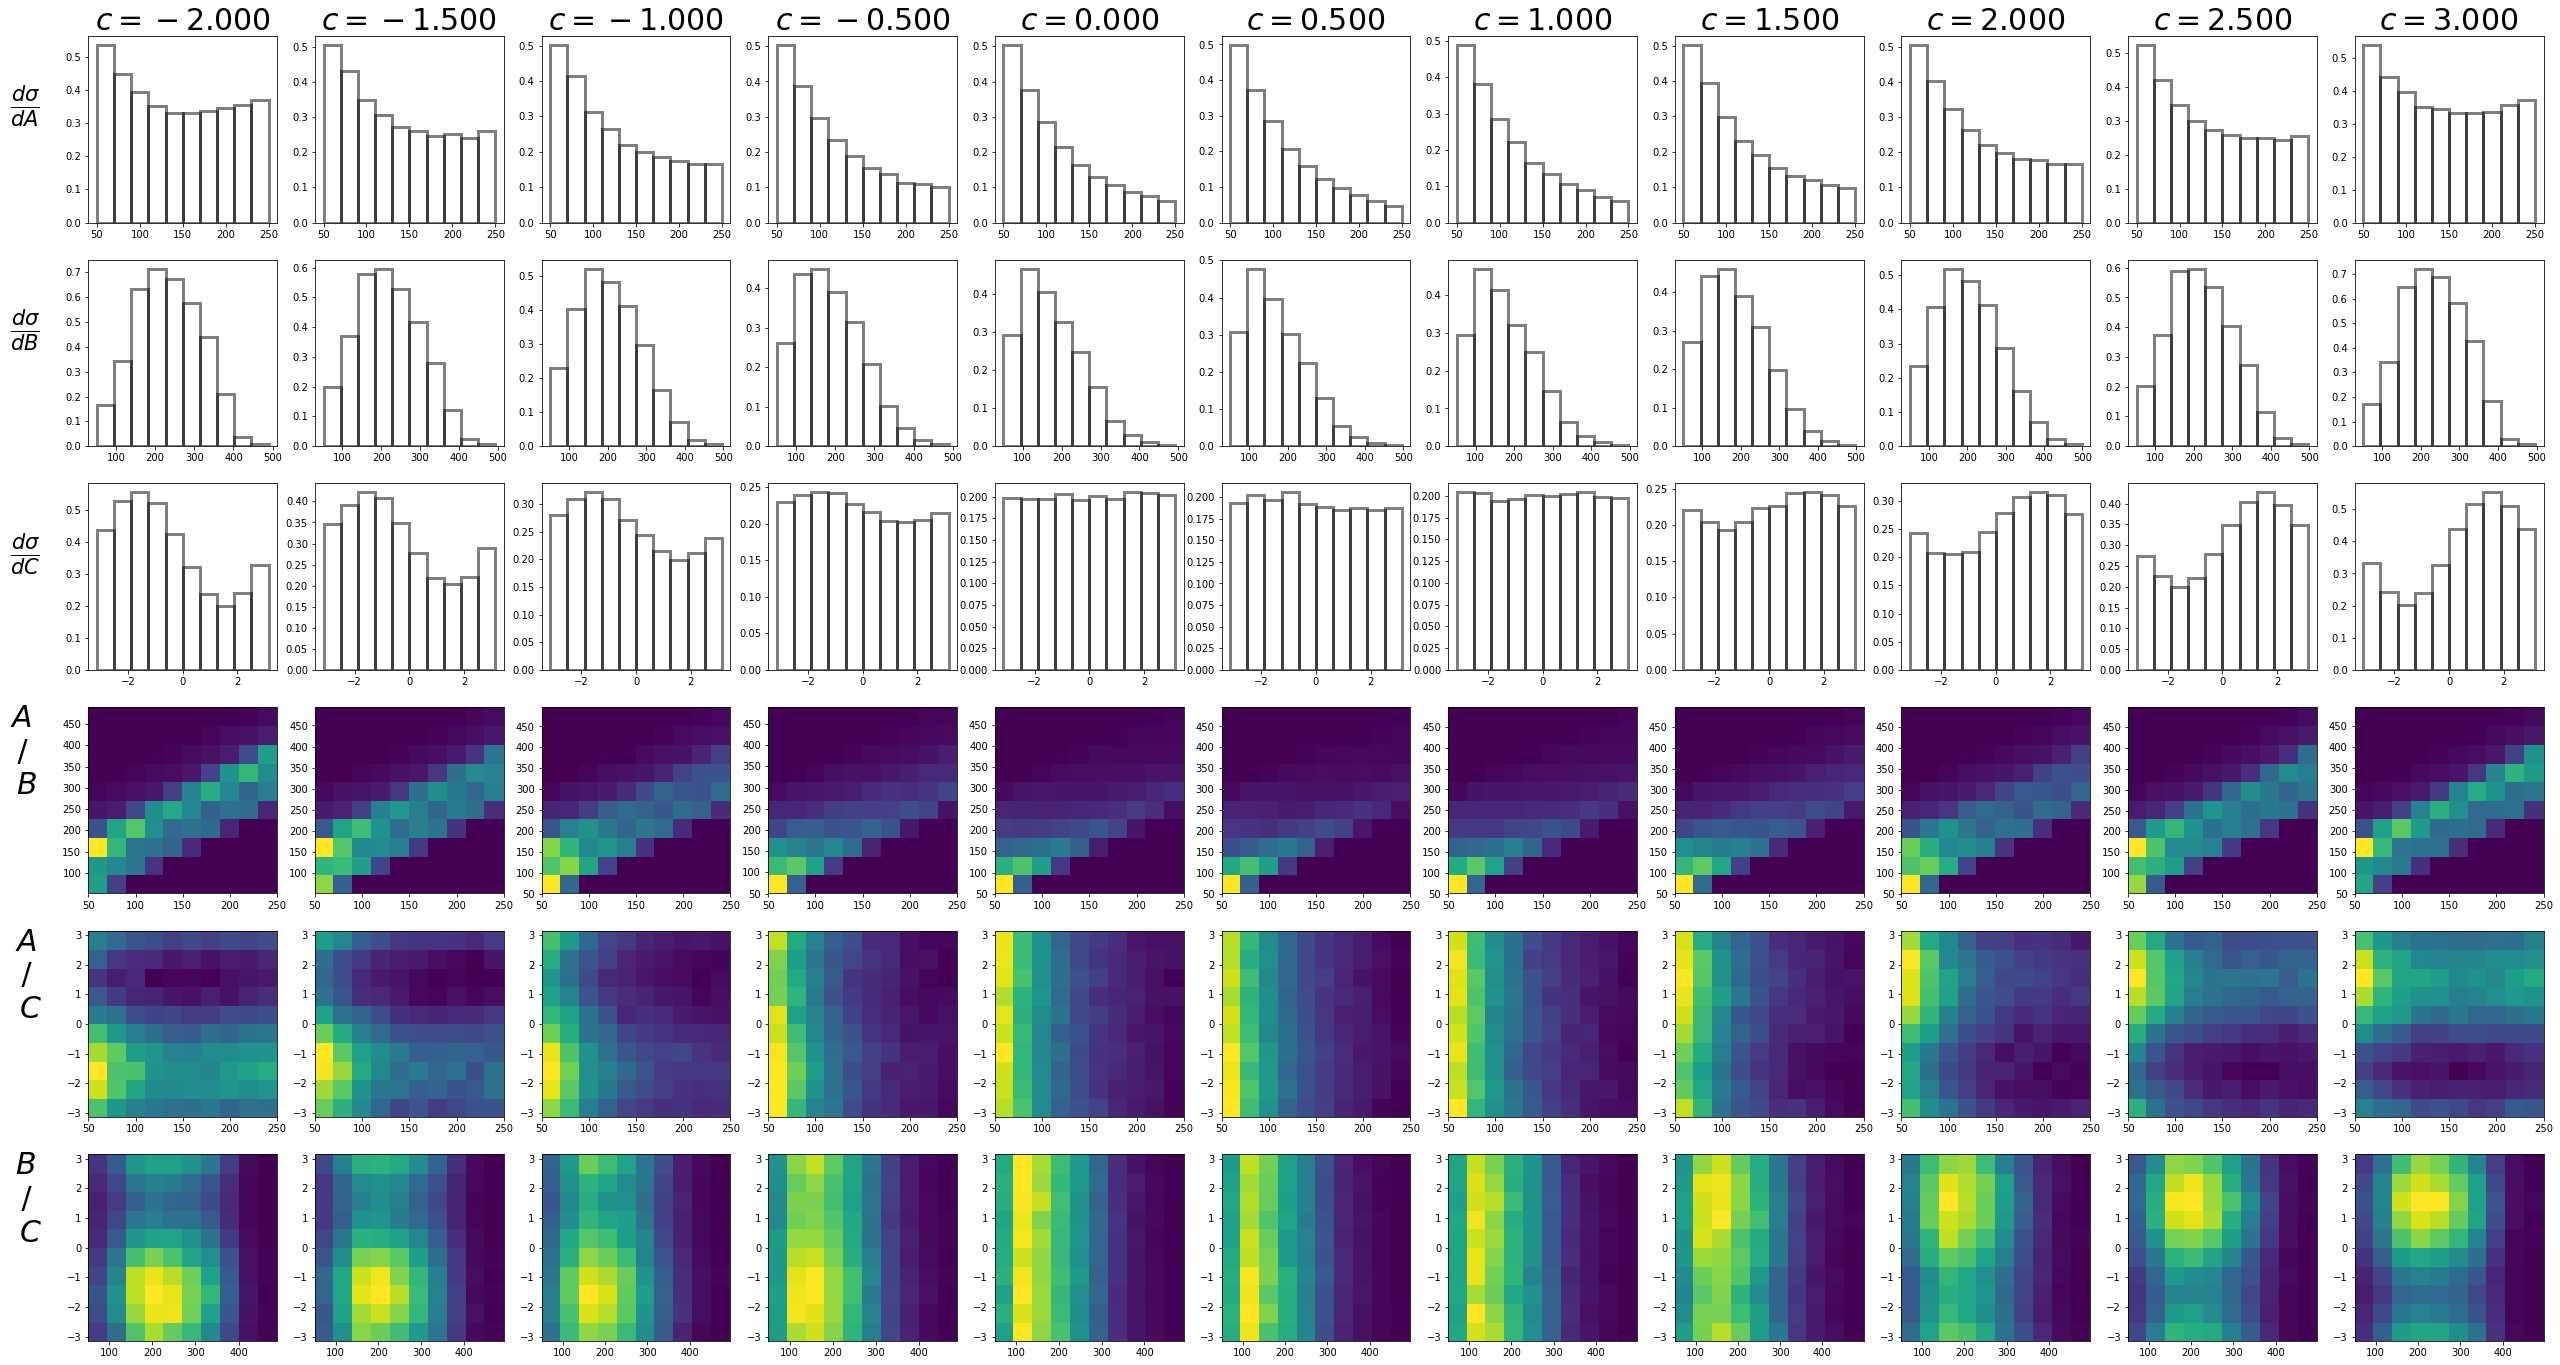

Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets


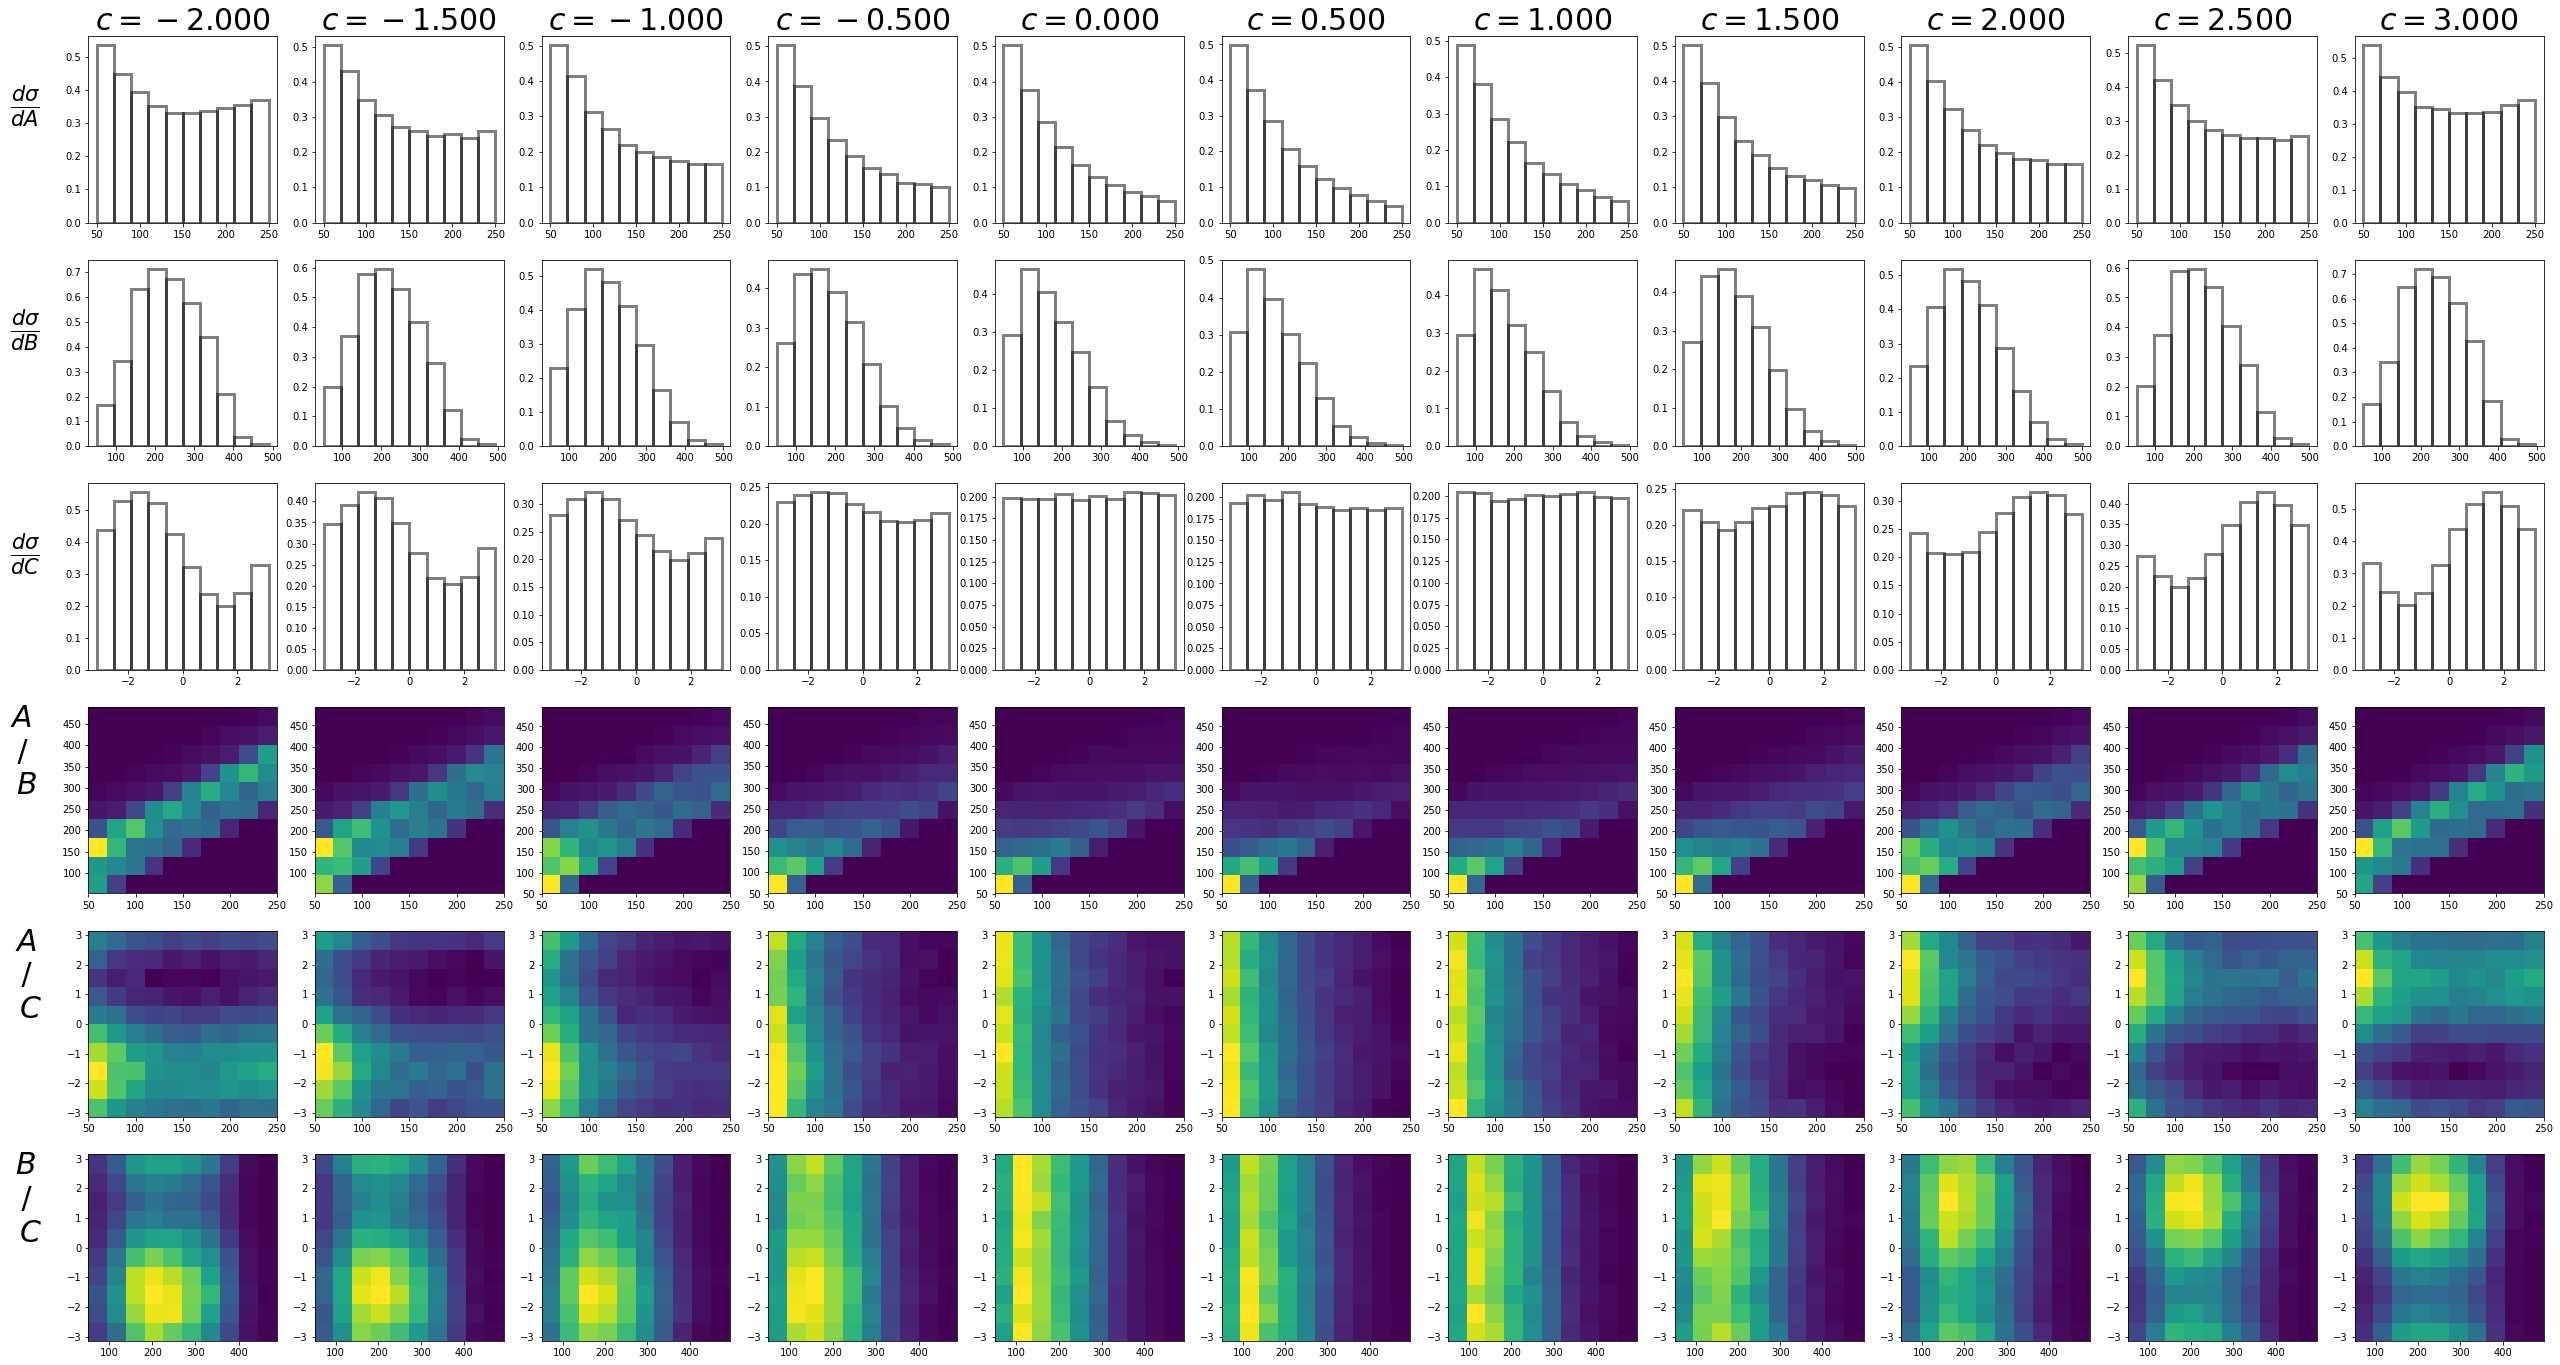

In [5]:
print("Plotting datasets")
#plot_dataset(mu_scan_points, xsections, datasets, weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, datasets, weights)

print("Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets")
#plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights)



Plotting whitened datasets


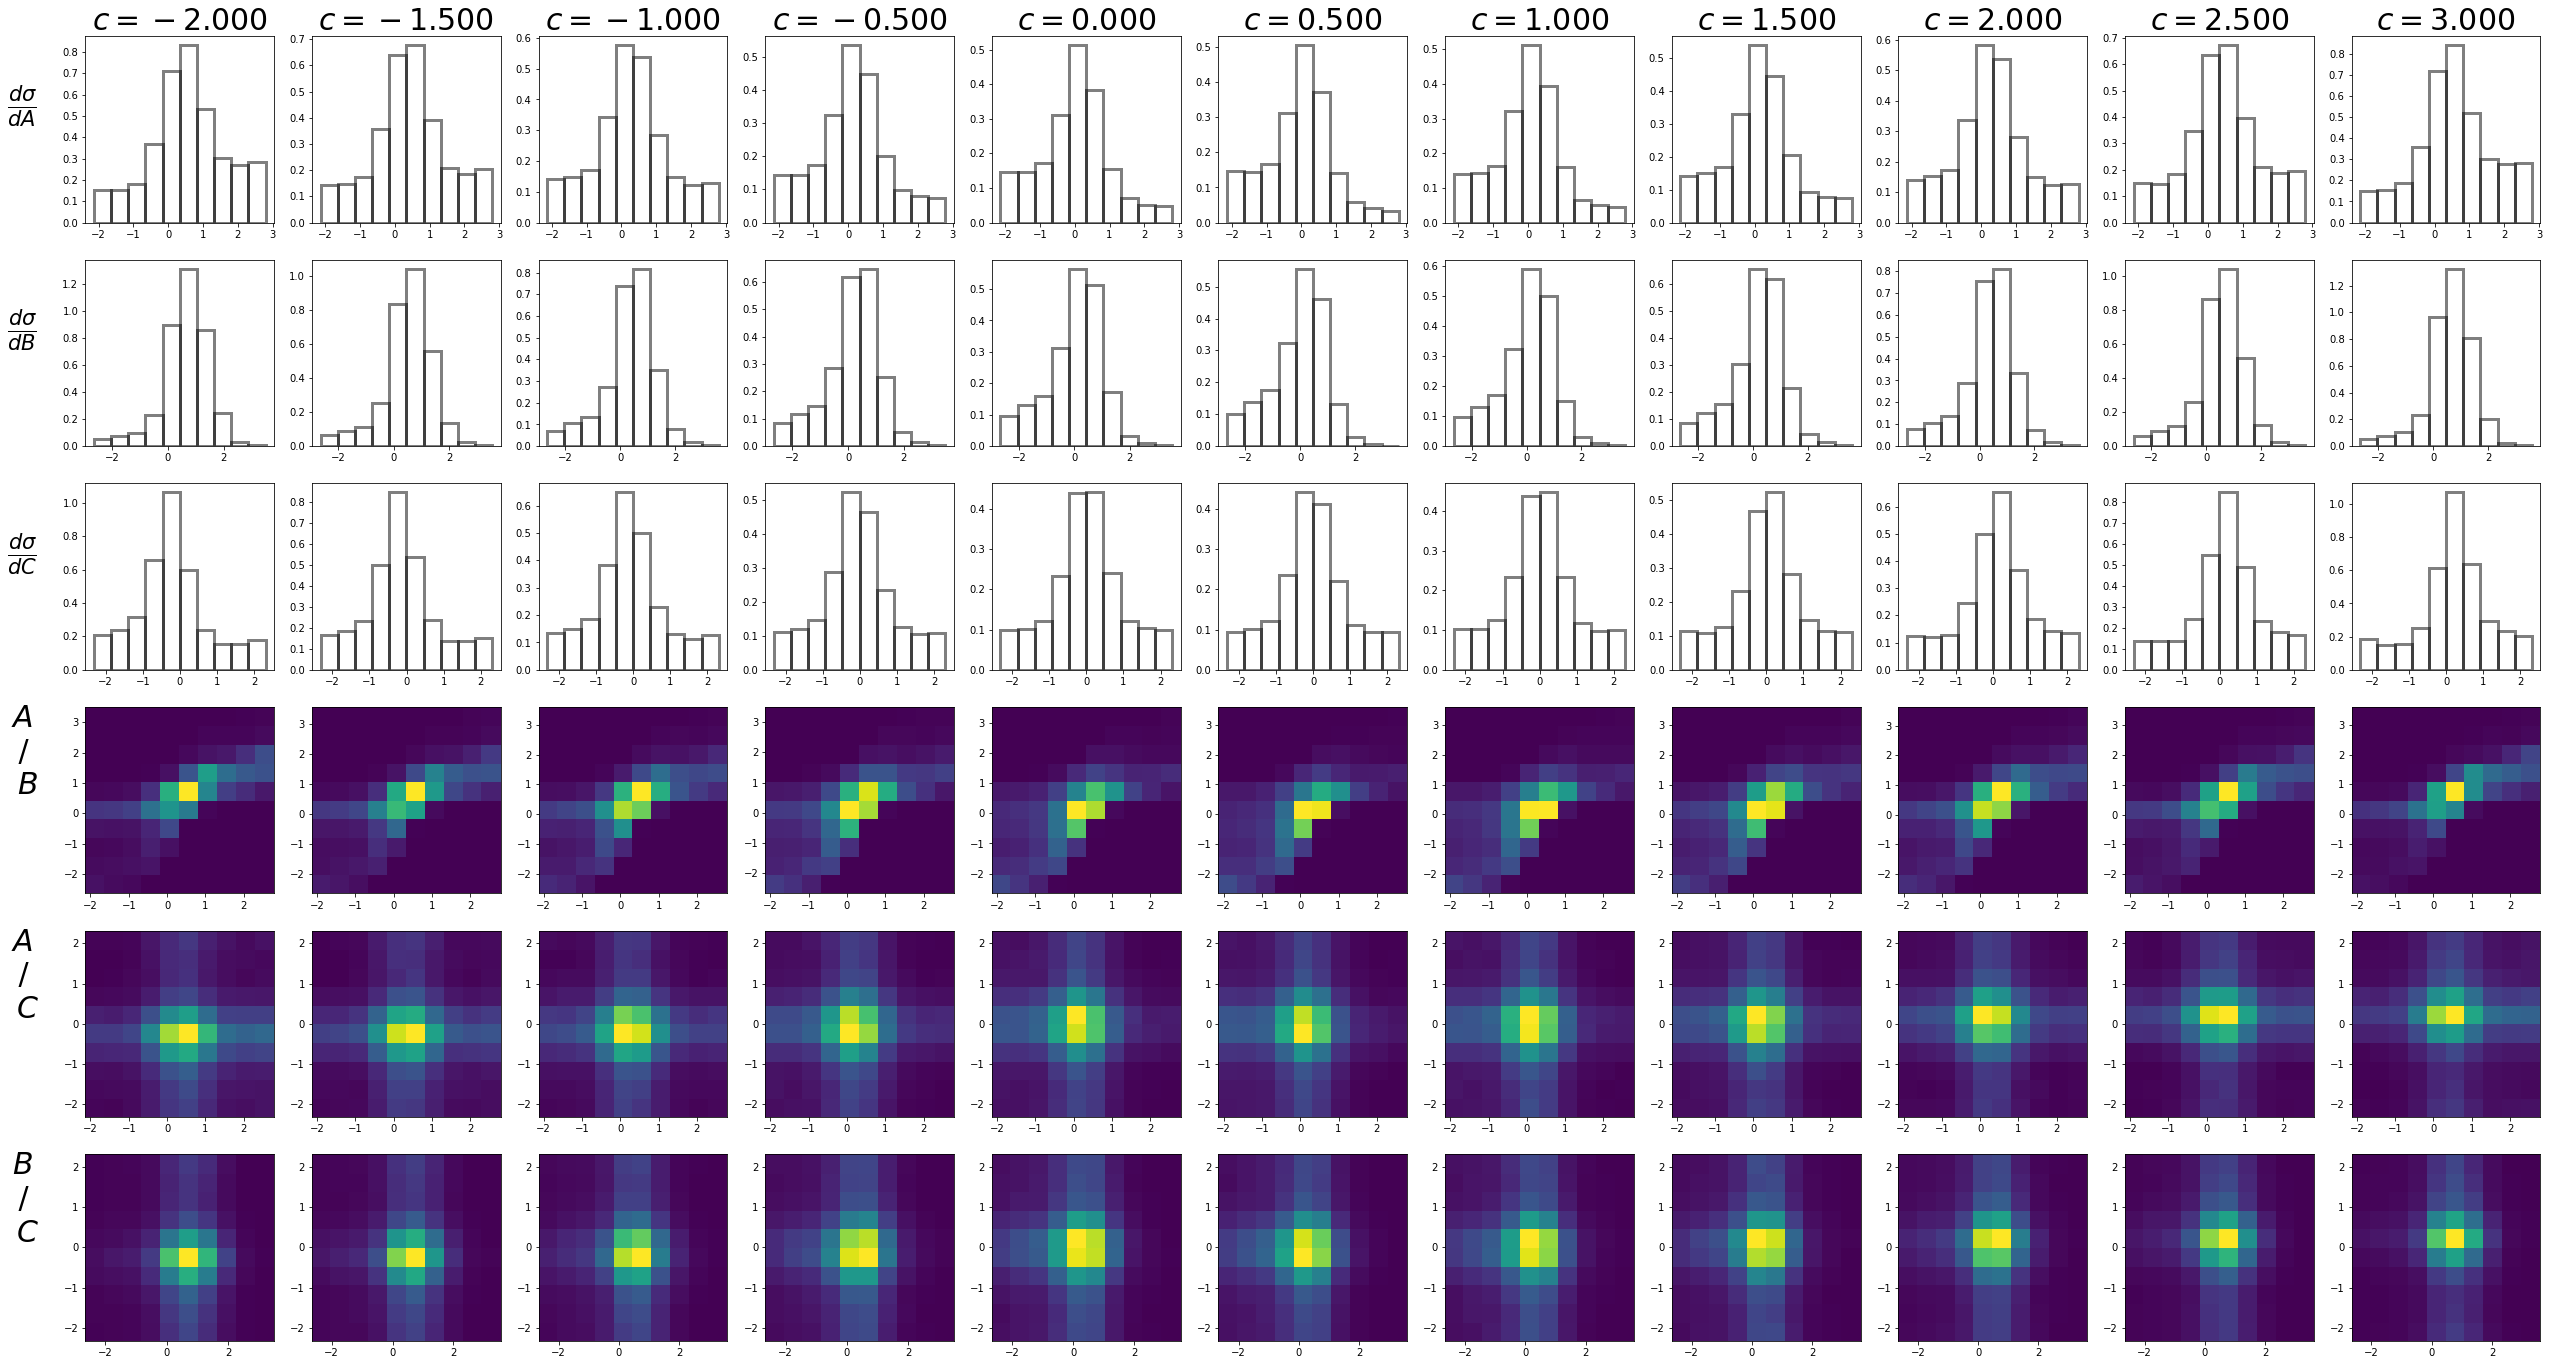

In [6]:
print("Plotting whitened datasets")
#plot_dataset(mu_scan_points, xsections, white_datasets, weights, ref=(xsec_SM, white_dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, white_datasets, weights)

In [7]:
def gauss_prob (x, mean, sigma) :
    prob = K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)
    return tf.where(tf.is_nan(prob), tf.zeros_like(prob), prob)


def datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob


def datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    log_L = K.log(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))
    return  log_L  # tf.where(tf.is_nan(log_L), -1e-12*tf.ones_like(log_L), log_L)


def dataset_mean_likelihood  (x, params, num_gauss) :
    return K.mean(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  


def dataset_likelihood (x, params, num_gauss) :
    prod_L = K.prod(datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))  
    return tf.where(tf.is_nan(prod_L), tf.zeros_like(prod_L), prod_L)
        

def dataset_mean_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K.mean(datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))    
    
    
def add_gauss_mean_offsets (x, num_gauss, offset_min, offset_max):
    c = tf.convert_to_tensor([offset_min + (offset_max-offset_min)*i/(num_gauss-1.) for i in range(num_gauss)])
    return x + c


def add_gauss_fraction_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def add_gauss_sigma_offsets (x, num_gauss):
    c = tf.convert_to_tensor([0. for i in range(num_gauss)])
    return x + c


def create_autoreg_density_model (name, **kwargs) :
    #  Parse arguments
    #
    num_conditions_in  = int (kwargs.get("num_conditions_in"    ))
    num_observables_in = int (kwargs.get("num_observables_in", 0))
    num_gaussians      = int (kwargs.get("num_gaussians"     , 5))
    verbose            = bool(kwargs.get("verbose" , True))
    
    #  Print a status message
    #
    if verbose : 
        print(f"Creating density model: {name}")
        print(f"  - num_conditions_in  is {num_conditions_in}")
        print(f"  - num_observables_in is {num_observables_in}")
        print(f"  - num_gaussians      is {num_gaussians}")
    
    #  Create model
    #
    conditions_input  = Input((num_conditions_in ,))
    model_conditions  = Dense      (10 )(conditions_input ) 
    model_conditions  = LeakyReLU  (0.2)(model_conditions )
    '''model_conditions  = Dense      (10 )(model_conditions )
    model_conditions  = LeakyReLU  (0.2)(model_conditions )''' 
    if num_observables_in > 0 :
        observables_input = Input((num_observables_in,))
        model_observables = Dense      (3*num_observables_in)(observables_input)    
        model_observables = LeakyReLU  (0.2                 )(model_observables)
        '''model_observables = Dense      (3*num_observables_in)(model_observables)    
        model_observables = LeakyReLU  (0.2                 )(model_conditions )'''
        model             = Concatenate(   )([model_conditions, model_observables])
    else :
        model = model_conditions
    #model             = Dropout    (0.1)(model)
    #model             = Dense      (10 + 2*num_gaussians + 3*num_observables_in)(model)
    #model             = Dropout    (0.1)(model)
    #model             = LeakyReLU  (0.2)(model)
    #model             = Dense      (10 + 2*num_gaussians + 3*num_observables_in)(model)
    #model             = LeakyReLU  (0.2)(model)
    gauss_means       = Dense      (3*num_gaussians )(model          )
    gauss_means       = LeakyReLU  (0.2             )(gauss_means    )
    gauss_sigmas      = Dense      (3*num_gaussians )(model          )
    gauss_sigmas      = LeakyReLU  (0.2             )(gauss_sigmas   )
    gauss_fractions   = Dense      (3*num_gaussians )(model          )
    gauss_fractions   = LeakyReLU  (0.2             )(gauss_fractions)
    
    gauss_means       = Dense (num_gaussians, activation="linear"  )(gauss_means)
    add_initial_mean_offsets = lambda x : add_gauss_mean_offsets(x, num_gaussians, -5, 5)
    gauss_means              = Lambda(add_initial_mean_offsets)(gauss_means)
    
    add_initial_sigma_offsets = lambda x : add_gauss_sigma_offsets(x, num_gaussians)
    gauss_sigmas              = Dense (num_gaussians                       )(gauss_sigmas)
    gauss_sigmas              = Lambda(add_initial_sigma_offsets           )(gauss_sigmas)
    gauss_sigmas              = Dense (num_gaussians, activation="softplus")(gauss_sigmas)
    
    add_initial_frac_offsets = lambda x : add_gauss_fraction_offsets(x, num_gaussians)
    gauss_fractions          = Dense  (num_gaussians                       )(gauss_fractions)
    gauss_fractions          = Lambda (add_initial_frac_offsets            )(gauss_fractions)
    gauss_fractions          = Softmax(                                    )(gauss_fractions)
    #gauss_fractions          = Dense (num_gaussians, activation="softmax" )(gauss_fractions)
    
    model             = Concatenate()([gauss_fractions, gauss_means, gauss_sigmas])
    if num_observables_in > 0 : model = Model ([conditions_input, observables_input], model)
    else                      : model = Model (conditions_input, model)
    
    loss_function = lambda y_true, y_pred : -1. * dataset_mean_log_likelihood (y_true, y_pred, num_gaussians)
    model.compile(loss=loss_function, optimizer=Adam())    
    if verbose : model.summary()
        
    return model

In [ ]:
class DensityModel :
    def __init__ (self, **kwargs) :
        self.construct(name, num_gaussians, num_conditions, num_observables, verbose=verbose)
    def construct (self, name=None, num_gaussians=None, num_conditions=None, num_observables=None, verbose=True)
        name            = kwargs.get("name"           , None)
        num_gaussians   = kwargs.get("num_gaussians"  , None)
        num_conditions  = kwargs.get("num_conditions" , None)
        num_observables = kwargs.get("num_observables", None)
        verbose         = kwargs.get("verbose"        , True)        
        if (type(name)            == type(None)) and (hasattr(self, "name"           )) :
            if verbose      : print(f"No name argument provided - using stored value)
            name            = self.name
        if (type(num_gaussians)   == type(None)) and (hasattr(self, "num_gaussians"  )) :
            if verbose      : print(f"No num_gaussians argument provided - using stored value)
            num_gaussians   = self.num_gaussians
        if (type(num_conditions)  == type(None)) and (hasattr(self, "num_conditions" )) :
            if verbose      : print(f"No num_conditions argument provided - using stored value)
            num_conditions  = self.num_conditions
        if (type(num_observables) == type(None)) and (hasattr(self, "num_observables")) :
            if verbose      : print(f"No num_observables argument provided - using stored value)
            num_observables = self.num_observables
        if type(name)            != str : raise TypeError(f"name argument {name} of type {type(name)} where {type(int)} expected")
        if type(num_gaussians)   != int : raise TypeError(f"num_gaussians argument {num_gaussians} of type {type(num_gaussians)} where {type(int)} expected")
        if type(num_conditions)  != int : raise TypeError(f"num_conditions argument {num_conditions} of type {type(num_conditions)} where {type(int)} expected")
        if type(num_observables) != int : raise TypeError(f"num_observables argument {num_observables} of type {type(num_observables)} where {type(int)} expected")
        if num_gaussians   < 1 : raise ValueError(TypeError(f"num_gaussians must be > 0, but {num_gaussians} provided")
        if num_conditions  < 0 : raise ValueError(TypeError(f"num_conditions must be >= 0, but {num_conditions} provided")
        if num_observables < 1 : raise ValueError(TypeError(f"num_observables must be > 0, but {num_observables} provided")                     

In [8]:
test_datasets = {mu:ds[:,0] for mu, ds in white_datasets.items()}
density_model = create_autoreg_density_model("1D_density_model",
                                              num_conditions_in = 1                    ,
                                              num_gaussians     = output_size_per_stage,
                                              verbose           = True                 )
initial_params = density_model.predict([[0.]])[0]
print(initial_params[:output_size_per_stage])
print(initial_params[output_size_per_stage:2*output_size_per_stage])
print(initial_params[2*output_size_per_stage:3*output_size_per_stage])

Creating density model: 1D_density_model
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 10
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           20          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 10)           0           dense_1[0][0]                    
____________________________________________________________________________________________

In [9]:

train_data_Y = np.concatenate([ds for mu, ds in test_datasets.items()])
train_data_X = np.concatenate([np.full(fill_value=mu, shape=(len(ds),1)) for mu, ds in test_datasets.items()])
train_data_X, train_data_Y = joint_shuffle(train_data_X, train_data_Y)

train_batch_size = int(len(train_data_X)/5)

density_model.fit(train_data_X,
                  train_data_Y,
                  validation_split = 0.5,
                  epochs           = max_epochs,
                  shuffle          = True,
                  batch_size       = train_batch_size,
                  callbacks        = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, monitor="val_loss")])


Train on 275000 samples, validate on 275000 samples
Epoch 1/2000
275000/275000 [==============================] - 2s 7us/step - loss: 2.5077 - val_loss: 2.4628
Epoch 2/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.4474 - val_loss: 2.4057
Epoch 3/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.3912 - val_loss: 2.3530
Epoch 4/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.3397 - val_loss: 2.3047
Epoch 5/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.2923 - val_loss: 2.2597
Epoch 6/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.2480 - val_loss: 2.2177
Epoch 7/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.2067 - val_loss: 2.1785
Epoch 8/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.1680 - val_loss: 2.1414
Epoch 9/2000
275000/275000 [==============================] - 1s 2us/step - loss: 2.

275000/275000 [==============================] - 1s 3us/step - loss: 1.4571 - val_loss: 1.4555
Epoch 76/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4560 - val_loss: 1.4544
Epoch 77/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4548 - val_loss: 1.4532
Epoch 78/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4537 - val_loss: 1.4521
Epoch 79/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4526 - val_loss: 1.4510
Epoch 80/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4515 - val_loss: 1.4499
Epoch 81/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4504 - val_loss: 1.4487
Epoch 82/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4493 - val_loss: 1.4476
Epoch 83/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4482 - val_loss: 1.4464
Epoch 84/2000
275000/275000 [====

Epoch 150/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4122 - val_loss: 1.4111
Epoch 151/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4120 - val_loss: 1.4109
Epoch 152/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4118 - val_loss: 1.4107
Epoch 153/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4117 - val_loss: 1.4106
Epoch 154/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4115 - val_loss: 1.4104
Epoch 155/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4114 - val_loss: 1.4102
Epoch 156/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4112 - val_loss: 1.4101
Epoch 157/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4111 - val_loss: 1.4100
Epoch 158/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4110 - val_loss: 1.4098
Epoch 159/

275000/275000 [==============================] - 1s 3us/step - loss: 1.4072 - val_loss: 1.4061
Epoch 225/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4072 - val_loss: 1.4060
Epoch 226/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4072 - val_loss: 1.4060
Epoch 227/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4071 - val_loss: 1.4060
Epoch 228/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4071 - val_loss: 1.4059
Epoch 229/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4071 - val_loss: 1.4059
Epoch 230/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4070 - val_loss: 1.4058
Epoch 231/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4070 - val_loss: 1.4058
Epoch 232/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4069 - val_loss: 1.4058
Epoch 233/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.4051 - val_loss: 1.4039
Epoch 299/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4051 - val_loss: 1.4039
Epoch 300/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4050 - val_loss: 1.4039
Epoch 301/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4050 - val_loss: 1.4039
Epoch 302/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4050 - val_loss: 1.4038
Epoch 303/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4050 - val_loss: 1.4038
Epoch 304/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4050 - val_loss: 1.4038
Epoch 305/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4049 - val_loss: 1.4038
Epoch 306/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4049 - val_loss: 1.4037
Epoch 307/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.4019 - val_loss: 1.4007
Epoch 373/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4018 - val_loss: 1.4006
Epoch 374/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4017 - val_loss: 1.4004
Epoch 375/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4016 - val_loss: 1.4004
Epoch 376/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4015 - val_loss: 1.4003
Epoch 377/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4014 - val_loss: 1.4001
Epoch 378/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4013 - val_loss: 1.4000
Epoch 379/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.4011 - val_loss: 1.3999
Epoch 380/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.4010 - val_loss: 1.3998
Epoch 381/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3976 - val_loss: 1.3967
Epoch 447/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3977 - val_loss: 1.3966
Epoch 448/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3977 - val_loss: 1.3967
Epoch 449/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3976 - val_loss: 1.3967
Epoch 450/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3976 - val_loss: 1.3966
Epoch 451/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3976 - val_loss: 1.3966
Epoch 452/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3976 - val_loss: 1.3966
Epoch 453/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3976 - val_loss: 1.3966
Epoch 454/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3976 - val_loss: 1.3966
Epoch 455/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 521/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 522/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3963
Epoch 523/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 524/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 525/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3963
Epoch 526/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 527/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3962
Epoch 528/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3972 - val_loss: 1.3963
Epoch 529/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3971 - val_loss: 1.3961
Epoch 595/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 596/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 597/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 598/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 599/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 600/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 601/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 602/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 603/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 669/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 670/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 671/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 672/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 673/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 674/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 675/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 676/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3961
Epoch 677/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 743/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 744/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 745/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 746/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 747/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 748/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 749/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 750/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 751/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 817/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 818/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 819/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 820/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 821/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 822/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 823/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3970 - val_loss: 1.3960
Epoch 824/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3961
Epoch 825/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 891/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 892/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 893/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 894/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 895/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 896/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 897/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3961
Epoch 898/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 899/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 965/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 966/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 967/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 968/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 969/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 970/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 971/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3959
Epoch 972/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 973/2000
275000/275

275000/275000 [==============================] - 1s 2us/step - loss: 1.3969 - val_loss: 1.3960
Epoch 1039/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1040/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1041/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1042/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1043/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1044/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1045/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1046/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1047/2000
2

Epoch 1112/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1113/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1114/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1115/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3960
Epoch 1116/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1117/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1118/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1119/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
Epoch 1120/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3968 - val_loss: 1.3959
E

Epoch 1186/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3959
Epoch 1187/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1188/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1189/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3959
Epoch 1190/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1191/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1192/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1193/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
Epoch 1194/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3967 - val_loss: 1.3958
E

Epoch 1260/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3956
Epoch 1261/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1262/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1263/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1264/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1265/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1266/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1267/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3955
Epoch 1268/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3962 - val_loss: 1.3954
E

Epoch 1334/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3947 - val_loss: 1.3940
Epoch 1335/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3946 - val_loss: 1.3939
Epoch 1336/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3946 - val_loss: 1.3939
Epoch 1337/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3945 - val_loss: 1.3938
Epoch 1338/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3945 - val_loss: 1.3937
Epoch 1339/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3944 - val_loss: 1.3937
Epoch 1340/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3943 - val_loss: 1.3936
Epoch 1341/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3943 - val_loss: 1.3936
Epoch 1342/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3942 - val_loss: 1.3935
E

Epoch 1408/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3913 - val_loss: 1.3904
Epoch 1409/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3912 - val_loss: 1.3905
Epoch 1410/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3912 - val_loss: 1.3903
Epoch 1411/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3911 - val_loss: 1.3902
Epoch 1412/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3910 - val_loss: 1.3901
Epoch 1413/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3910 - val_loss: 1.3902
Epoch 1414/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3910 - val_loss: 1.3899
Epoch 1415/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3908 - val_loss: 1.3900
Epoch 1416/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3908 - val_loss: 1.3898
E

Epoch 1482/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3885
Epoch 1483/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3885
Epoch 1484/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3885
Epoch 1485/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1486/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3885
Epoch 1487/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1488/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1489/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3885
Epoch 1490/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3894 - val_loss: 1.3886
E

Epoch 1556/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3885
Epoch 1557/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3885
Epoch 1558/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1559/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3884
Epoch 1560/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3885
Epoch 1561/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1562/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3886
Epoch 1563/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
Epoch 1564/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3893 - val_loss: 1.3885
E

Epoch 1630/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1631/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1632/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1633/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1634/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1635/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1636/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1637/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3884
Epoch 1638/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
E

Epoch 1704/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3885
Epoch 1705/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3885
Epoch 1706/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3892 - val_loss: 1.3884
Epoch 1707/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1708/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3891 - val_loss: 1.3884
Epoch 1709/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1710/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1711/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1712/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3890 - val_loss: 1.3885
E

Epoch 1778/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3885
Epoch 1779/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1780/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1781/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1782/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1783/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3884
Epoch 1784/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1785/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
Epoch 1786/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3884
E

Epoch 1852/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1853/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3884
Epoch 1854/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1855/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3888 - val_loss: 1.3883
Epoch 1856/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1857/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1858/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1859/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1860/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
E

Epoch 1926/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3883
Epoch 1927/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3890 - val_loss: 1.3883
Epoch 1928/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3889 - val_loss: 1.3882
Epoch 1929/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3888 - val_loss: 1.3882
Epoch 1930/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3887 - val_loss: 1.3881
Epoch 1931/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3888 - val_loss: 1.3882
Epoch 1932/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3888 - val_loss: 1.3881
Epoch 1933/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3888 - val_loss: 1.3881
Epoch 1934/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3887 - val_loss: 1.3882
E

Epoch 2000/2000
275000/275000 [==============================] - 1s 2us/step - loss: 1.3884 - val_loss: 1.3880


In [10]:
def gauss_prob_np (x, mean, sigma) :
    return np.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / np.sqrt(2*np.pi*sigma*sigma)


def datapoint_likelihood_np (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[i] * gauss_prob_np(x, gauss_means[i], gauss_sigmas[i])
    return prob


def get_density (x, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    '''print(fracs)
    print(means)
    print(sigmas)'''
    return datapoint_likelihood_np (x, num_gauss, fracs, means, sigmas)


def sample_sum_gaussians (n_points, params) :
    num_gauss = int(len(params) / 3)
    fracs, means, sigmas = params[:num_gauss], params[num_gauss:2*num_gauss], params[2*num_gauss:3*num_gauss]
    which_gauss     = np.random.choice(num_gauss, size=(n_points,), p=fracs)
    n_pts_per_gauss = [len([x for x in which_gauss if x == i]) for i in range(num_gauss)]
    points = []
    for i in range(num_gauss) :
        points.append(np.random.normal(means[i], sigmas[i], n_pts_per_gauss[i]))
    return np.concatenate(points)

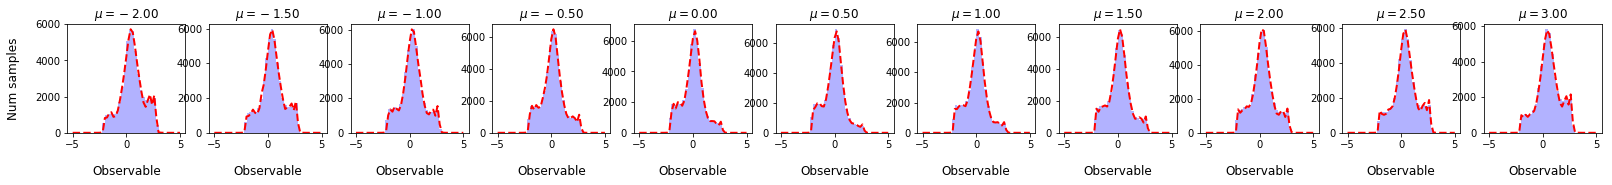

In [11]:

num_mu_scan_points = len(mu_scan_points)
fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
ax_lims = axis_lims[0]
for ax_idx, mu in enumerate(mu_scan_points) :
    ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
    plot_data  = test_datasets [mu]
    params = density_model.predict([mu])[0]
    #plot_fake  = sample_sum_gaussians(len(plot_data), params)
    x = np.linspace(ax_lims[0], ax_lims[1], 51)
    ax.plot(x, len(plot_data)*get_density(x, params)*(ax_lims[1]-ax_lims[0])/41, c="red", linestyle="--", linewidth=2)
    ax.hist(plot_data , bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    #ax.hist(plot_fake , bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="grey", alpha=0.3)
    ax.set_xlabel("Observable", fontsize=12, labelpad=15)
    if ax_idx == 0 : ax.set_ylabel("Num samples", fontsize=12, labelpad=15)
    ax.set_title(f"$\mu = {mu:.2f}$")
plt.show()

In [12]:
test2_datasets = {mu:ds[:,:2] for mu, ds in white_datasets.items()}
density_model2 = create_autoreg_density_model("2D_density_model",
                                              num_conditions_in  = 1                    ,
                                              num_observables_in = 1                    ,
                                              num_gaussians      = output_size_per_stage,
                                              verbose            = True                 )

Creating density model: 2D_density_model
  - num_conditions_in  is 1
  - num_observables_in is 1
  - num_gaussians      is 10
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 10)           20          input_2[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 3)            6           

In [13]:

train_data_Y, train_data_X_cond, train_data_X_obs = [], [], []
for mu, ds in test2_datasets.items() :
    for dp in ds :
        train_data_X_cond.append(mu)
        train_data_X_obs .append(dp[0])
        train_data_Y     .append(dp[1])
train_data_Y, train_data_X_cond, train_data_X_obs = joint_shuffle(train_data_Y, train_data_X_cond, train_data_X_obs)

density_model2.fit([train_data_X_cond, train_data_X_obs],
                   train_data_Y,
                   validation_split = 0.5,
                   epochs           = max_epochs,
                   shuffle          = True,
                   batch_size       = train_batch_size,
                   callbacks        = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, monitor="val_loss")])


Train on 275000 samples, validate on 275000 samples
Epoch 1/2000
275000/275000 [==============================] - 2s 7us/step - loss: 2.4184 - val_loss: 2.3474
Epoch 2/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.3237 - val_loss: 2.2632
Epoch 3/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.2421 - val_loss: 2.1891
Epoch 4/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.1698 - val_loss: 2.1222
Epoch 5/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.1044 - val_loss: 2.0609
Epoch 6/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.0443 - val_loss: 2.0036
Epoch 7/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9878 - val_loss: 1.9490
Epoch 8/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9342 - val_loss: 1.8984
Epoch 9/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.

275000/275000 [==============================] - 1s 3us/step - loss: 0.7906 - val_loss: 0.7876
Epoch 76/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7874 - val_loss: 0.7845
Epoch 77/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7844 - val_loss: 0.7814
Epoch 78/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7813 - val_loss: 0.7783
Epoch 79/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7782 - val_loss: 0.7752
Epoch 80/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7753 - val_loss: 0.7721
Epoch 81/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7722 - val_loss: 0.7690
Epoch 82/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7691 - val_loss: 0.7659
Epoch 83/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7660 - val_loss: 0.7629
Epoch 84/2000
275000/275000 [====

Epoch 150/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7014 - val_loss: 0.7003
Epoch 151/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7009 - val_loss: 0.6998
Epoch 152/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.7003 - val_loss: 0.6992
Epoch 153/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6997 - val_loss: 0.6986
Epoch 154/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6992 - val_loss: 0.6980
Epoch 155/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6986 - val_loss: 0.6975
Epoch 156/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6980 - val_loss: 0.6968
Epoch 157/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6974 - val_loss: 0.6962
Epoch 158/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6968 - val_loss: 0.6957
Epoch 159/

275000/275000 [==============================] - 1s 3us/step - loss: 0.6693 - val_loss: 0.6694
Epoch 225/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6691 - val_loss: 0.6693
Epoch 226/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6689 - val_loss: 0.6691
Epoch 227/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6688 - val_loss: 0.6690
Epoch 228/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6686 - val_loss: 0.6688
Epoch 229/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6685 - val_loss: 0.6687
Epoch 230/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6684 - val_loss: 0.6686
Epoch 231/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6682 - val_loss: 0.6683
Epoch 232/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6680 - val_loss: 0.6682
Epoch 233/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6608 - val_loss: 0.6612
Epoch 299/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6607 - val_loss: 0.6611
Epoch 300/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6606 - val_loss: 0.6609
Epoch 301/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6606 - val_loss: 0.6609
Epoch 302/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6604 - val_loss: 0.6608
Epoch 303/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6604 - val_loss: 0.6607
Epoch 304/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6602 - val_loss: 0.6606
Epoch 305/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6602 - val_loss: 0.6605
Epoch 306/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6601 - val_loss: 0.6604
Epoch 307/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6547 - val_loss: 0.6550
Epoch 373/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6546 - val_loss: 0.6550
Epoch 374/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6546 - val_loss: 0.6549
Epoch 375/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6545 - val_loss: 0.6548
Epoch 376/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6544 - val_loss: 0.6547
Epoch 377/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6544 - val_loss: 0.6547
Epoch 378/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6542 - val_loss: 0.6546
Epoch 379/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6541 - val_loss: 0.6543
Epoch 380/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6540 - val_loss: 0.6544
Epoch 381/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6437 - val_loss: 0.6435
Epoch 447/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6433 - val_loss: 0.6433
Epoch 448/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6434 - val_loss: 0.6435
Epoch 449/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6432 - val_loss: 0.6434
Epoch 450/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6431 - val_loss: 0.6432
Epoch 451/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6430 - val_loss: 0.6433
Epoch 452/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6430 - val_loss: 0.6431
Epoch 453/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6428 - val_loss: 0.6430
Epoch 454/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6427 - val_loss: 0.6428
Epoch 455/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6407 - val_loss: 0.6407
Epoch 521/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6406 - val_loss: 0.6407
Epoch 522/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6405 - val_loss: 0.6408
Epoch 523/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6406 - val_loss: 0.6404
Epoch 524/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6405 - val_loss: 0.6407
Epoch 525/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6405 - val_loss: 0.6404
Epoch 526/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6403 - val_loss: 0.6404
Epoch 527/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6404 - val_loss: 0.6405
Epoch 528/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6404 - val_loss: 0.6404
Epoch 529/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6392 - val_loss: 0.6391
Epoch 595/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6391 - val_loss: 0.6394
Epoch 596/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6393 - val_loss: 0.6393
Epoch 597/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6392 - val_loss: 0.6392
Epoch 598/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6391 - val_loss: 0.6393
Epoch 599/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6391 - val_loss: 0.6393
Epoch 600/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6392 - val_loss: 0.6393
Epoch 601/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6392 - val_loss: 0.6393
Epoch 602/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6392 - val_loss: 0.6395
Epoch 603/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6382 - val_loss: 0.6383
Epoch 669/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6382 - val_loss: 0.6382
Epoch 670/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6381 - val_loss: 0.6384
Epoch 671/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6383 - val_loss: 0.6385
Epoch 672/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6383 - val_loss: 0.6381
Epoch 673/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6381 - val_loss: 0.6382
Epoch 674/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6380 - val_loss: 0.6381
Epoch 675/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6380 - val_loss: 0.6380
Epoch 676/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6380 - val_loss: 0.6378
Epoch 677/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6370
Epoch 743/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6371 - val_loss: 0.6370
Epoch 744/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6369
Epoch 745/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6371
Epoch 746/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6371
Epoch 747/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6371
Epoch 748/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6370 - val_loss: 0.6370
Epoch 749/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6369 - val_loss: 0.6370
Epoch 750/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6369 - val_loss: 0.6370
Epoch 751/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6365
Epoch 817/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6364 - val_loss: 0.6365
Epoch 818/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6364 - val_loss: 0.6365
Epoch 819/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6363 - val_loss: 0.6362
Epoch 820/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6363
Epoch 821/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6361
Epoch 822/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6362
Epoch 823/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6361
Epoch 824/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6362 - val_loss: 0.6367
Epoch 825/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6355 - val_loss: 0.6357
Epoch 891/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6355 - val_loss: 0.6355
Epoch 892/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6356 - val_loss: 0.6356
Epoch 893/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6356 - val_loss: 0.6357
Epoch 894/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6355 - val_loss: 0.6355
Epoch 895/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6354 - val_loss: 0.6358
Epoch 896/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6356 - val_loss: 0.6355
Epoch 897/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6354 - val_loss: 0.6355
Epoch 898/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6353 - val_loss: 0.6354
Epoch 899/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6347 - val_loss: 0.6349
Epoch 965/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6349 - val_loss: 0.6352
Epoch 966/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6349 - val_loss: 0.6353
Epoch 967/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6350 - val_loss: 0.6351
Epoch 968/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6348 - val_loss: 0.6349
Epoch 969/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6348 - val_loss: 0.6349
Epoch 970/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6346 - val_loss: 0.6348
Epoch 971/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6347 - val_loss: 0.6348
Epoch 972/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6347 - val_loss: 0.6349
Epoch 973/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 0.6343 - val_loss: 0.6345
Epoch 1039/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6342 - val_loss: 0.6342
Epoch 1040/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6341 - val_loss: 0.6347
Epoch 1041/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6345 - val_loss: 0.6349
Epoch 1042/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6345 - val_loss: 0.6344
Epoch 1043/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6344 - val_loss: 0.6345
Epoch 1044/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6342 - val_loss: 0.6341
Epoch 1045/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6340 - val_loss: 0.6343
Epoch 1046/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6340 - val_loss: 0.6342
Epoch 1047/2000
2

Epoch 1112/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6336 - val_loss: 0.6340
Epoch 1113/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6337 - val_loss: 0.6340
Epoch 1114/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6335 - val_loss: 0.6336
Epoch 1115/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6333 - val_loss: 0.6339
Epoch 1116/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6334 - val_loss: 0.6335
Epoch 1117/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6332 - val_loss: 0.6336
Epoch 1118/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6332 - val_loss: 0.6336
Epoch 1119/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6333 - val_loss: 0.6335
Epoch 1120/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6332 - val_loss: 0.6335
E

Epoch 1186/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6332 - val_loss: 0.6339
Epoch 1187/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6334 - val_loss: 0.6330
Epoch 1188/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6330 - val_loss: 0.6337
Epoch 1189/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6330 - val_loss: 0.6330
Epoch 1190/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6329 - val_loss: 0.6331
Epoch 1191/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6327 - val_loss: 0.6331
Epoch 1192/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6326 - val_loss: 0.6329
Epoch 1193/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6325 - val_loss: 0.6330
Epoch 1194/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6326 - val_loss: 0.6331
E

Epoch 1260/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6321 - val_loss: 0.6325
Epoch 1261/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6320 - val_loss: 0.6324
Epoch 1262/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6321 - val_loss: 0.6325
Epoch 1263/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6321 - val_loss: 0.6326
Epoch 1264/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6321 - val_loss: 0.6324
Epoch 1265/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6320 - val_loss: 0.6325
Epoch 1266/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6321 - val_loss: 0.6323
Epoch 1267/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6319 - val_loss: 0.6324
Epoch 1268/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6320 - val_loss: 0.6324
E

Epoch 1334/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6315 - val_loss: 0.6322
Epoch 1335/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6322
Epoch 1336/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6322
Epoch 1337/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6320
Epoch 1338/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6321
Epoch 1339/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6321
Epoch 1340/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6317 - val_loss: 0.6323
Epoch 1341/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6318 - val_loss: 0.6324
Epoch 1342/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6320 - val_loss: 0.6320
E

Epoch 1408/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6312 - val_loss: 0.6318
Epoch 1409/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6313 - val_loss: 0.6316
Epoch 1410/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6312 - val_loss: 0.6317
Epoch 1411/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6312 - val_loss: 0.6317
Epoch 1412/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6312 - val_loss: 0.6316
Epoch 1413/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6311 - val_loss: 0.6316
Epoch 1414/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6311 - val_loss: 0.6316
Epoch 1415/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6311 - val_loss: 0.6317
Epoch 1416/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6311 - val_loss: 0.6317
E

Epoch 1482/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6309 - val_loss: 0.6315
Epoch 1483/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6309 - val_loss: 0.6318
Epoch 1484/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6310 - val_loss: 0.6314
Epoch 1485/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6308 - val_loss: 0.6314
Epoch 1486/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6309 - val_loss: 0.6312
Epoch 1487/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6308 - val_loss: 0.6312
Epoch 1488/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6307 - val_loss: 0.6313
Epoch 1489/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6308 - val_loss: 0.6313
Epoch 1490/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6308 - val_loss: 0.6311
E

Epoch 1556/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6302 - val_loss: 0.6307
Epoch 1557/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6301 - val_loss: 0.6308
Epoch 1558/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6302 - val_loss: 0.6306
Epoch 1559/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6301 - val_loss: 0.6307
Epoch 1560/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6302 - val_loss: 0.6307
Epoch 1561/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6303 - val_loss: 0.6306
Epoch 1562/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6301 - val_loss: 0.6307
Epoch 1563/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6302 - val_loss: 0.6309
Epoch 1564/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6303 - val_loss: 0.6306
E

Epoch 1630/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6298 - val_loss: 0.6304
Epoch 1631/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6297 - val_loss: 0.6303
Epoch 1632/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6297 - val_loss: 0.6305
Epoch 1633/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6299 - val_loss: 0.6302
Epoch 1634/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6299 - val_loss: 0.6305
Epoch 1635/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6298 - val_loss: 0.6304
Epoch 1636/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6298 - val_loss: 0.6304
Epoch 1637/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6297 - val_loss: 0.6303
Epoch 1638/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6297 - val_loss: 0.6305
E

Epoch 1704/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6293 - val_loss: 0.6300
Epoch 1705/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6293 - val_loss: 0.6300
Epoch 1706/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6294 - val_loss: 0.6300
Epoch 1707/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6293 - val_loss: 0.6302
Epoch 1708/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6294 - val_loss: 0.6298
Epoch 1709/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6294 - val_loss: 0.6304
Epoch 1710/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6297 - val_loss: 0.6299
Epoch 1711/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6293 - val_loss: 0.6298
Epoch 1712/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6291 - val_loss: 0.6297
E

Epoch 1778/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6287 - val_loss: 0.6289
Epoch 1779/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6285 - val_loss: 0.6292
Epoch 1780/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6284 - val_loss: 0.6290
Epoch 1781/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6284 - val_loss: 0.6291
Epoch 1782/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6283 - val_loss: 0.6291
Epoch 1783/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6284 - val_loss: 0.6290
Epoch 1784/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6285 - val_loss: 0.6290
Epoch 1785/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6284 - val_loss: 0.6289
Epoch 1786/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6284 - val_loss: 0.6289
E

Epoch 1852/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6278 - val_loss: 0.6285
Epoch 1853/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6277 - val_loss: 0.6282
Epoch 1854/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6276 - val_loss: 0.6282
Epoch 1855/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6275 - val_loss: 0.6283
Epoch 1856/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6276 - val_loss: 0.6284
Epoch 1857/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6278 - val_loss: 0.6285
Epoch 1858/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6276 - val_loss: 0.6284
Epoch 1859/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6278 - val_loss: 0.6283
Epoch 1860/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6277 - val_loss: 0.6284
E

Epoch 1926/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6271 - val_loss: 0.6277
Epoch 1927/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6272 - val_loss: 0.6281
Epoch 1928/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6273 - val_loss: 0.6276
Epoch 1929/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6271 - val_loss: 0.6277
Epoch 1930/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6272 - val_loss: 0.6277
Epoch 1931/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6271 - val_loss: 0.6275
Epoch 1932/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6269 - val_loss: 0.6276
Epoch 1933/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6270 - val_loss: 0.6276
Epoch 1934/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6270 - val_loss: 0.6278
E

Epoch 2000/2000
275000/275000 [==============================] - 1s 3us/step - loss: 0.6264 - val_loss: 0.6269


In [14]:
def sample_2D (mu, n_points) :
    params = density_model.predict([mu])[0]
    X1 = sample_sum_gaussians (n_points, params)
    X2 = []
    for i, x1 in enumerate(X1) :
        params2 = density_model2.predict([[mu], [x1]])[0]
        X2.append(sample_sum_gaussians (1, params2)[0])
    X2 = np.array(X2)
    return np.array([X1, X2]).transpose()

def get_density_2D (mu, x, y) :
    params_x  = density_model.predict([mu])[0]
    density_x = get_density (x, params_x)
    params_y  = density_model2.predict([[mu], [x]])[0]
    density_y = get_density (y, params_y)
    return density_x*density_y

Getting fakes for mu = -2.00
Getting contour for mu = -2.00
Getting fakes for mu = -1.50
Getting contour for mu = -1.50
Getting fakes for mu = -1.00
Getting contour for mu = -1.00
Getting fakes for mu = -0.50
Getting contour for mu = -0.50
Getting fakes for mu = 0.00
Getting contour for mu = 0.00
Getting fakes for mu = 0.50
Getting contour for mu = 0.50
Getting fakes for mu = 1.00
Getting contour for mu = 1.00
Getting fakes for mu = 1.50
Getting contour for mu = 1.50
Getting fakes for mu = 2.00
Getting contour for mu = 2.00
Getting fakes for mu = 2.50
Getting contour for mu = 2.50
Getting fakes for mu = 3.00
Getting contour for mu = 3.00


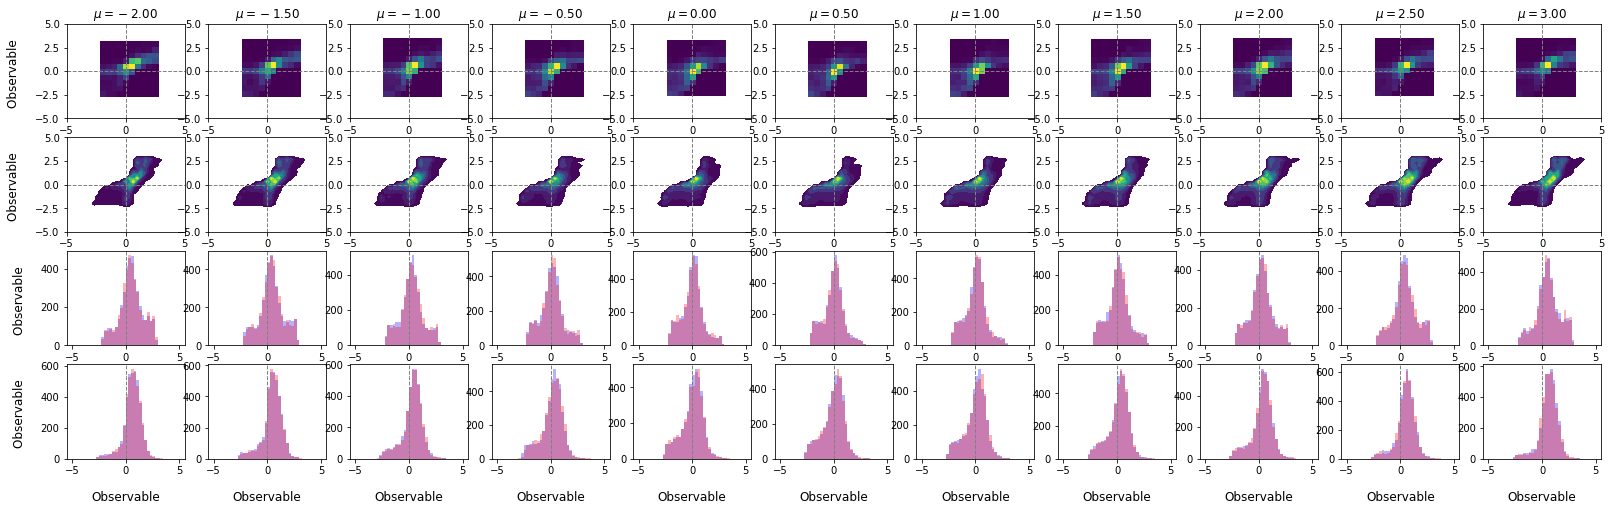

In [17]:

num_mu_scan_points = len(mu_scan_points)
fig = plt.figure(figsize=(2.5*num_mu_scan_points, 8))
ax_lims = axis_lims[0]
for ax_idx, mu in enumerate(mu_scan_points) :
    ax1 = fig.add_subplot(4, num_mu_scan_points, 1+ax_idx)
    plot_data  = test2_datasets [mu][:4000]
    ax1.hist2d(plot_data[:,0], plot_data[:,1])
    ax1.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax1.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    #ax2 = fig.add_subplot(5, num_mu_scan_points, num_mu_scan_points+1+ax_idx)
    print(f"Getting fakes for mu = {mu:.2f}")
    plot_fakes = sample_2D(mu, 4000)
    '''ax2.hist2d(plot_fakes[:,0], plot_fakes[:,1])
    ax2.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax2.axvline(0, linestyle="--", c="gray", linewidth=1.)'''
    
    ax3 = fig.add_subplot(4, num_mu_scan_points, 1*num_mu_scan_points+1+ax_idx)
    print(f"Getting contour for mu = {mu:.2f}")
    x, y = np.linspace(ax_lims[0], ax_lims[1], 31), np.linspace(ax_lims[0], ax_lims[1], 31)
    x_grid, y_grid = np.meshgrid(x, y)
    z = np.zeros(shape=x_grid.shape)
    for i, xp in enumerate(x) :
        for j, yp in enumerate(y) :
            z [i, j] = get_density_2D(mu, xp, yp)
    z = z / np.max(z)
    ax3.contourf(x, y, z, levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ax3.axhline(0, linestyle="--", c="gray", linewidth=1.)
    ax3.axvline(0, linestyle="--", c="gray", linewidth=1.)
          
    ax1.set_xlim([ax_lims[0], ax_lims[1]])
    ax1.set_ylim([ax_lims[0], ax_lims[1]])
    '''ax2.set_xlim([ax_lims[0], ax_lims[1]])
    ax2.set_ylim([ax_lims[0], ax_lims[1]])'''
    ax3.set_xlim([ax_lims[0], ax_lims[1]])
    ax3.set_ylim([ax_lims[0], ax_lims[1]])
    
    ax4 = fig.add_subplot(4, num_mu_scan_points, 2*num_mu_scan_points+1+ax_idx)
    ax4.hist(plot_data [:,0], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    ax4.hist(plot_fakes[:,0], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="red" , alpha=0.3)
    ax4.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    ax5 = fig.add_subplot(4, num_mu_scan_points, 3*num_mu_scan_points+1+ax_idx)
    ax5.hist(plot_data [:,1], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="blue", alpha=0.3)
    ax5.hist(plot_fakes[:,1], bins=np.linspace(ax_lims[0], ax_lims[1], 41), color="red" , alpha=0.3)
    ax5.axvline(0, linestyle="--", c="gray", linewidth=1.)
    
    #x, y = np.linspace(-5, 5, 51), np.linspace(-5, 5, 51)

    ax5.set_xlabel("Observable", fontsize=12, labelpad=15)
    ax1.set_title(f"$\mu = {mu:.2f}$")
    if ax_idx == 0 : 
        ax1.set_ylabel("Observable ", fontsize=12, labelpad=15)
        #ax2.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax3.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax4.set_ylabel("Observable ", fontsize=12, labelpad=15)
        ax5.set_ylabel("Observable ", fontsize=12, labelpad=15)
plt.show()

In [18]:
test3_datasets = {mu:ds[:,:3] for mu, ds in white_datasets.items()}
density_model3 = create_autoreg_density_model("3D_density_model",
                                              num_conditions_in  = 1                    ,
                                              num_observables_in = 2                    ,
                                              num_gaussians      = output_size_per_stage,
                                              verbose            = True                 )

Creating density model: 3D_density_model
  - num_conditions_in  is 1
  - num_observables_in is 2
  - num_gaussians      is 10
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 10)           20          input_4[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 6)            18          

In [19]:

train_data_Y, train_data_X_cond, train_data_X_obs1, train_data_X_obs2 = [], [], [], []
for mu, ds in test3_datasets.items() :
    for dp in ds :
        train_data_X_cond.append(mu)
        train_data_X_obs1.append(dp[0])
        train_data_X_obs2.append(dp[1])
        train_data_Y     .append(dp[2])
train_data_Y, train_data_X_cond, train_data_X_obs1, train_data_X_obs2 = joint_shuffle(train_data_Y, train_data_X_cond, train_data_X_obs1, train_data_X_obs2)

density_model3.fit([train_data_X_cond, np.array([train_data_X_obs1, train_data_X_obs2]).transpose()],
                   train_data_Y,
                   validation_split = 0.5,
                   epochs           = max_epochs,
                   shuffle          = True,
                   batch_size       = train_batch_size,
                   callbacks        = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True, monitor="val_loss")])



Train on 275000 samples, validate on 275000 samples
Epoch 1/2000
275000/275000 [==============================] - 2s 7us/step - loss: 2.3720 - val_loss: 2.3120
Epoch 2/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.2920 - val_loss: 2.2373
Epoch 3/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.2188 - val_loss: 2.1686
Epoch 4/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.1514 - val_loss: 2.1049
Epoch 5/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.0889 - val_loss: 2.0458
Epoch 6/2000
275000/275000 [==============================] - 1s 3us/step - loss: 2.0308 - val_loss: 1.9907
Epoch 7/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9768 - val_loss: 1.9398
Epoch 8/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.9269 - val_loss: 1.8929
Epoch 9/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.

275000/275000 [==============================] - 1s 3us/step - loss: 1.3694 - val_loss: 1.3690
Epoch 76/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3684 - val_loss: 1.3680
Epoch 77/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3674 - val_loss: 1.3669
Epoch 78/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3664 - val_loss: 1.3659
Epoch 79/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3653 - val_loss: 1.3649
Epoch 80/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3644 - val_loss: 1.3639
Epoch 81/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3634 - val_loss: 1.3630
Epoch 82/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3624 - val_loss: 1.3620
Epoch 83/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3615 - val_loss: 1.3611
Epoch 84/2000
275000/275000 [====

Epoch 150/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3408 - val_loss: 1.3406
Epoch 151/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3407 - val_loss: 1.3406
Epoch 152/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3406 - val_loss: 1.3404
Epoch 153/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3405 - val_loss: 1.3403
Epoch 154/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3404 - val_loss: 1.3403
Epoch 155/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3403 - val_loss: 1.3402
Epoch 156/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3403 - val_loss: 1.3401
Epoch 157/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3402 - val_loss: 1.3401
Epoch 158/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3401 - val_loss: 1.3400
Epoch 159/

275000/275000 [==============================] - 1s 3us/step - loss: 1.3375 - val_loss: 1.3374
Epoch 225/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3374 - val_loss: 1.3374
Epoch 226/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3374 - val_loss: 1.3374
Epoch 227/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3374 - val_loss: 1.3374
Epoch 228/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3374 - val_loss: 1.3374
Epoch 229/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3373 - val_loss: 1.3373
Epoch 230/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3373 - val_loss: 1.3373
Epoch 231/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3373 - val_loss: 1.3373
Epoch 232/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3372 - val_loss: 1.3373
Epoch 233/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3355
Epoch 299/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3355
Epoch 300/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3355
Epoch 301/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3355
Epoch 302/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3354 - val_loss: 1.3355
Epoch 303/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3353 - val_loss: 1.3355
Epoch 304/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3353 - val_loss: 1.3354
Epoch 305/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3353 - val_loss: 1.3354
Epoch 306/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3352 - val_loss: 1.3354
Epoch 307/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3347
Epoch 373/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3347
Epoch 374/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 375/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 376/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 377/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 378/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 379/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 380/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3344 - val_loss: 1.3346
Epoch 381/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 447/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3340 - val_loss: 1.3342
Epoch 448/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 449/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 450/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 451/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 452/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3340 - val_loss: 1.3342
Epoch 453/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3340 - val_loss: 1.3342
Epoch 454/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3339 - val_loss: 1.3342
Epoch 455/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 521/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 522/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 523/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 524/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 525/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 526/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 527/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 528/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3337 - val_loss: 1.3340
Epoch 529/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3339
Epoch 595/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3339
Epoch 596/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3339
Epoch 597/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3338
Epoch 598/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3338
Epoch 599/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3338
Epoch 600/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3338
Epoch 601/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3338
Epoch 602/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3335 - val_loss: 1.3339
Epoch 603/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 669/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3336
Epoch 670/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 671/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 672/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 673/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 674/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 675/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 676/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3332 - val_loss: 1.3337
Epoch 677/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3332
Epoch 743/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3332
Epoch 744/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3332
Epoch 745/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3331
Epoch 746/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3331
Epoch 747/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3326 - val_loss: 1.3331
Epoch 748/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3327 - val_loss: 1.3331
Epoch 749/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3326 - val_loss: 1.3331
Epoch 750/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3326 - val_loss: 1.3330
Epoch 751/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3260 - val_loss: 1.3258
Epoch 817/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3257 - val_loss: 1.3256
Epoch 818/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3256 - val_loss: 1.3254
Epoch 819/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3255 - val_loss: 1.3254
Epoch 820/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3253 - val_loss: 1.3254
Epoch 821/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3253 - val_loss: 1.3251
Epoch 822/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3252 - val_loss: 1.3251
Epoch 823/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3251 - val_loss: 1.3250
Epoch 824/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3249 - val_loss: 1.3249
Epoch 825/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3235 - val_loss: 1.3236
Epoch 891/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3236
Epoch 892/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3236 - val_loss: 1.3236
Epoch 893/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3235 - val_loss: 1.3235
Epoch 894/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3235
Epoch 895/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3236
Epoch 896/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3235
Epoch 897/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3236
Epoch 898/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3234 - val_loss: 1.3237
Epoch 899/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3232 - val_loss: 1.3235
Epoch 965/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3234
Epoch 966/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3234
Epoch 967/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3233
Epoch 968/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3234
Epoch 969/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3234
Epoch 970/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3234
Epoch 971/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3233
Epoch 972/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3233
Epoch 973/2000
275000/275

275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3233
Epoch 1039/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3229 - val_loss: 1.3233
Epoch 1040/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3233
Epoch 1041/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3233
Epoch 1042/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3233
Epoch 1043/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3231 - val_loss: 1.3233
Epoch 1044/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3234
Epoch 1045/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3234
Epoch 1046/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3230 - val_loss: 1.3234
Epoch 1047/2000
2

Epoch 1112/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3228 - val_loss: 1.3232
Epoch 1113/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1114/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3228 - val_loss: 1.3232
Epoch 1115/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1116/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1117/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1118/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1119/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3227 - val_loss: 1.3232
Epoch 1120/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3228 - val_loss: 1.3232
E

Epoch 1186/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1187/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3226
Epoch 1188/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1189/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1190/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1191/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1192/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3223 - val_loss: 1.3227
Epoch 1193/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3222 - val_loss: 1.3226
Epoch 1194/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3222 - val_loss: 1.3226
E

Epoch 1260/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3213 - val_loss: 1.3217
Epoch 1261/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3216
Epoch 1262/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3216
Epoch 1263/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3217
Epoch 1264/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3216
Epoch 1265/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3211 - val_loss: 1.3217
Epoch 1266/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3217
Epoch 1267/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3211 - val_loss: 1.3216
Epoch 1268/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3212 - val_loss: 1.3216
E

Epoch 1334/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1335/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1336/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1337/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1338/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1339/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1340/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1341/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1342/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
E

Epoch 1408/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1409/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3213
Epoch 1410/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3215
Epoch 1411/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1412/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1413/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3215
Epoch 1414/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1415/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3208 - val_loss: 1.3214
Epoch 1416/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3215
E

Epoch 1482/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1483/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3214
Epoch 1484/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3213
Epoch 1485/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1486/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1487/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3214
Epoch 1488/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1489/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
Epoch 1490/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3214
E

Epoch 1556/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3213
Epoch 1557/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
Epoch 1558/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
Epoch 1559/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
Epoch 1560/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1561/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
Epoch 1562/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3214
Epoch 1563/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3207 - val_loss: 1.3214
Epoch 1564/2000
275000/275000 [==============================] - 1s 3us/step - loss: 1.3206 - val_loss: 1.3213
E

In [20]:
def sample_3D (mu, n_points) :
    params = density_model.predict([mu])[0]
    X1 = sample_sum_gaussians (n_points, params)
    X2, X3 = [], []
    for i, x1 in enumerate(X1) :
        params2 = density_model2.predict([[mu], [x1]])[0]
        x2      = sample_sum_gaussians (1, params2)[0]
        params3 = density_model3.predict([np.array([mu,]), np.array([[x1, x2],])])[0]
        x3      = sample_sum_gaussians (1, params3)[0]
        X2.append(x2)
        X3.append(x3)
    X2 = np.array(X2)
    X3 = np.array(X3)
    return np.array([X1, X2, X3]).transpose()


In [21]:
fake_DS = {}
num_gen_per_mu = 50000

for mu in mu_scan_points :
    print(f"Getting fakes for mu = {mu:.2f}")
    fake_DS [mu] = sample_3D(mu, num_gen_per_mu)

Getting fakes for mu = -2.00
Getting fakes for mu = -1.50
Getting fakes for mu = -1.00
Getting fakes for mu = -0.50
Getting fakes for mu = 0.00
Getting fakes for mu = 0.50
Getting fakes for mu = 1.00
Getting fakes for mu = 1.50
Getting fakes for mu = 2.00
Getting fakes for mu = 2.50
Getting fakes for mu = 3.00


In [22]:
fake_weights = {mu:np.full(fill_value=1./len(ds), shape=(len(ds),)) for mu,ds in fake_DS.items()}

Plotting fake dataset


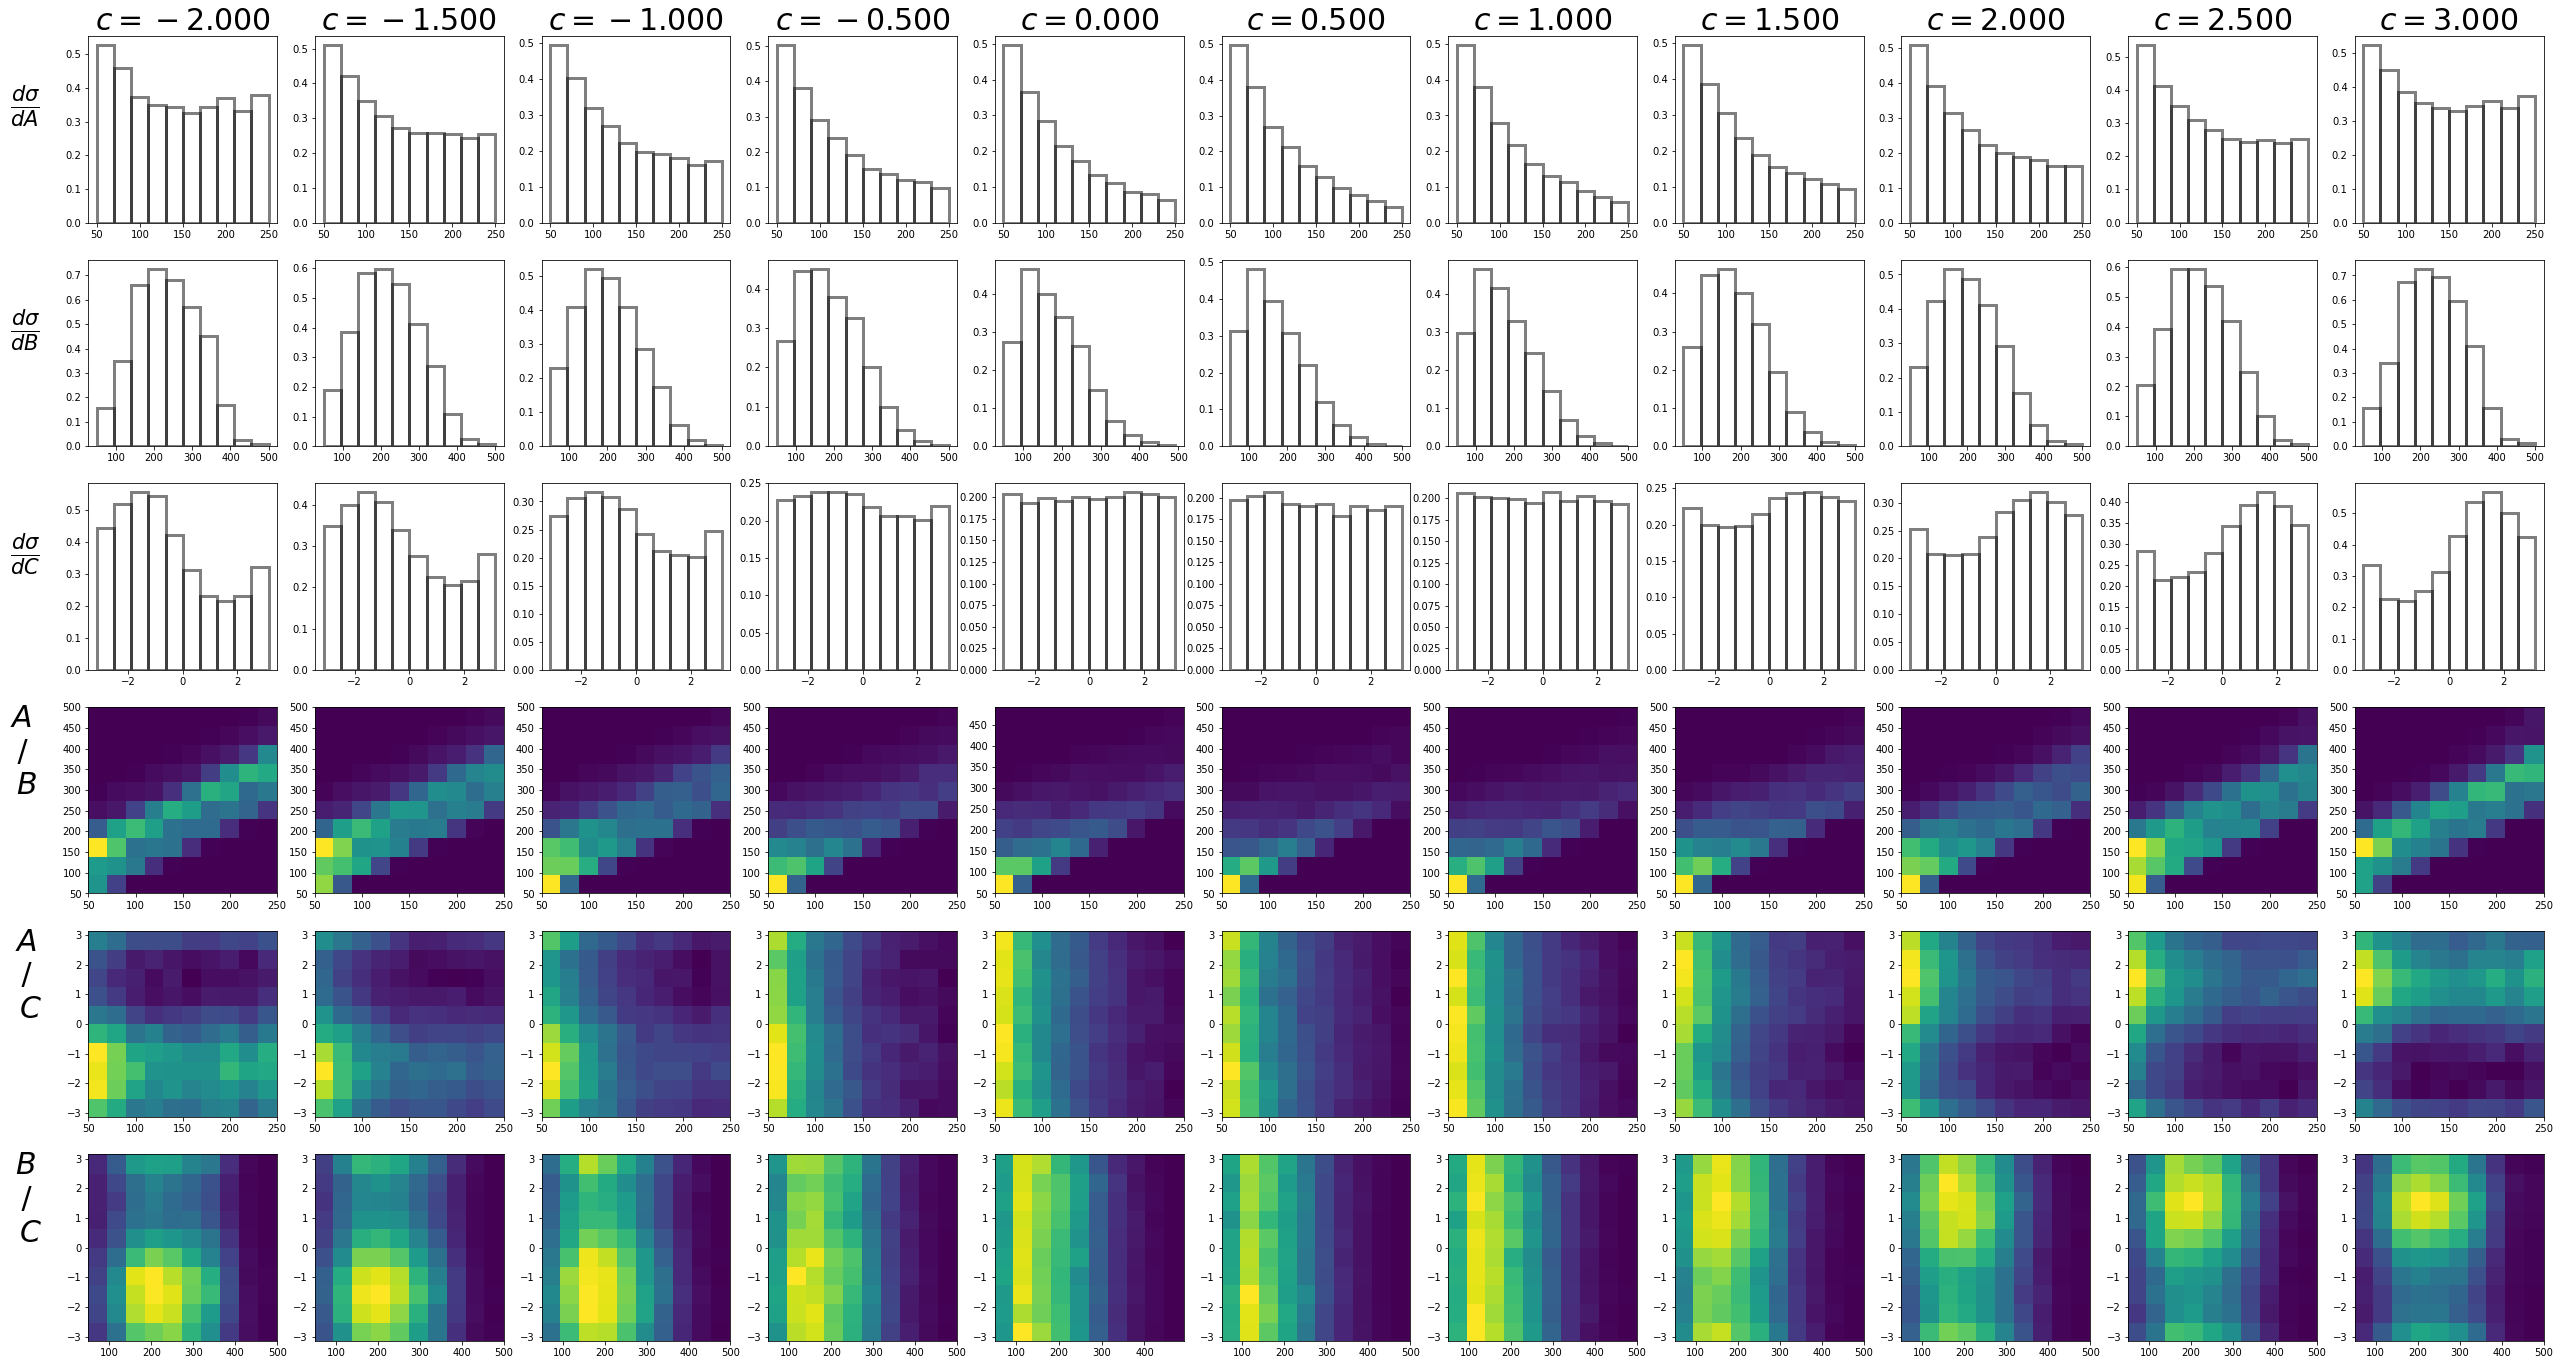

In [23]:
print("Plotting fake dataset")
plot_dataset(mu_scan_points, xsections, unwhiten_data(fake_DS), fake_weights)

Plotting fake dataset


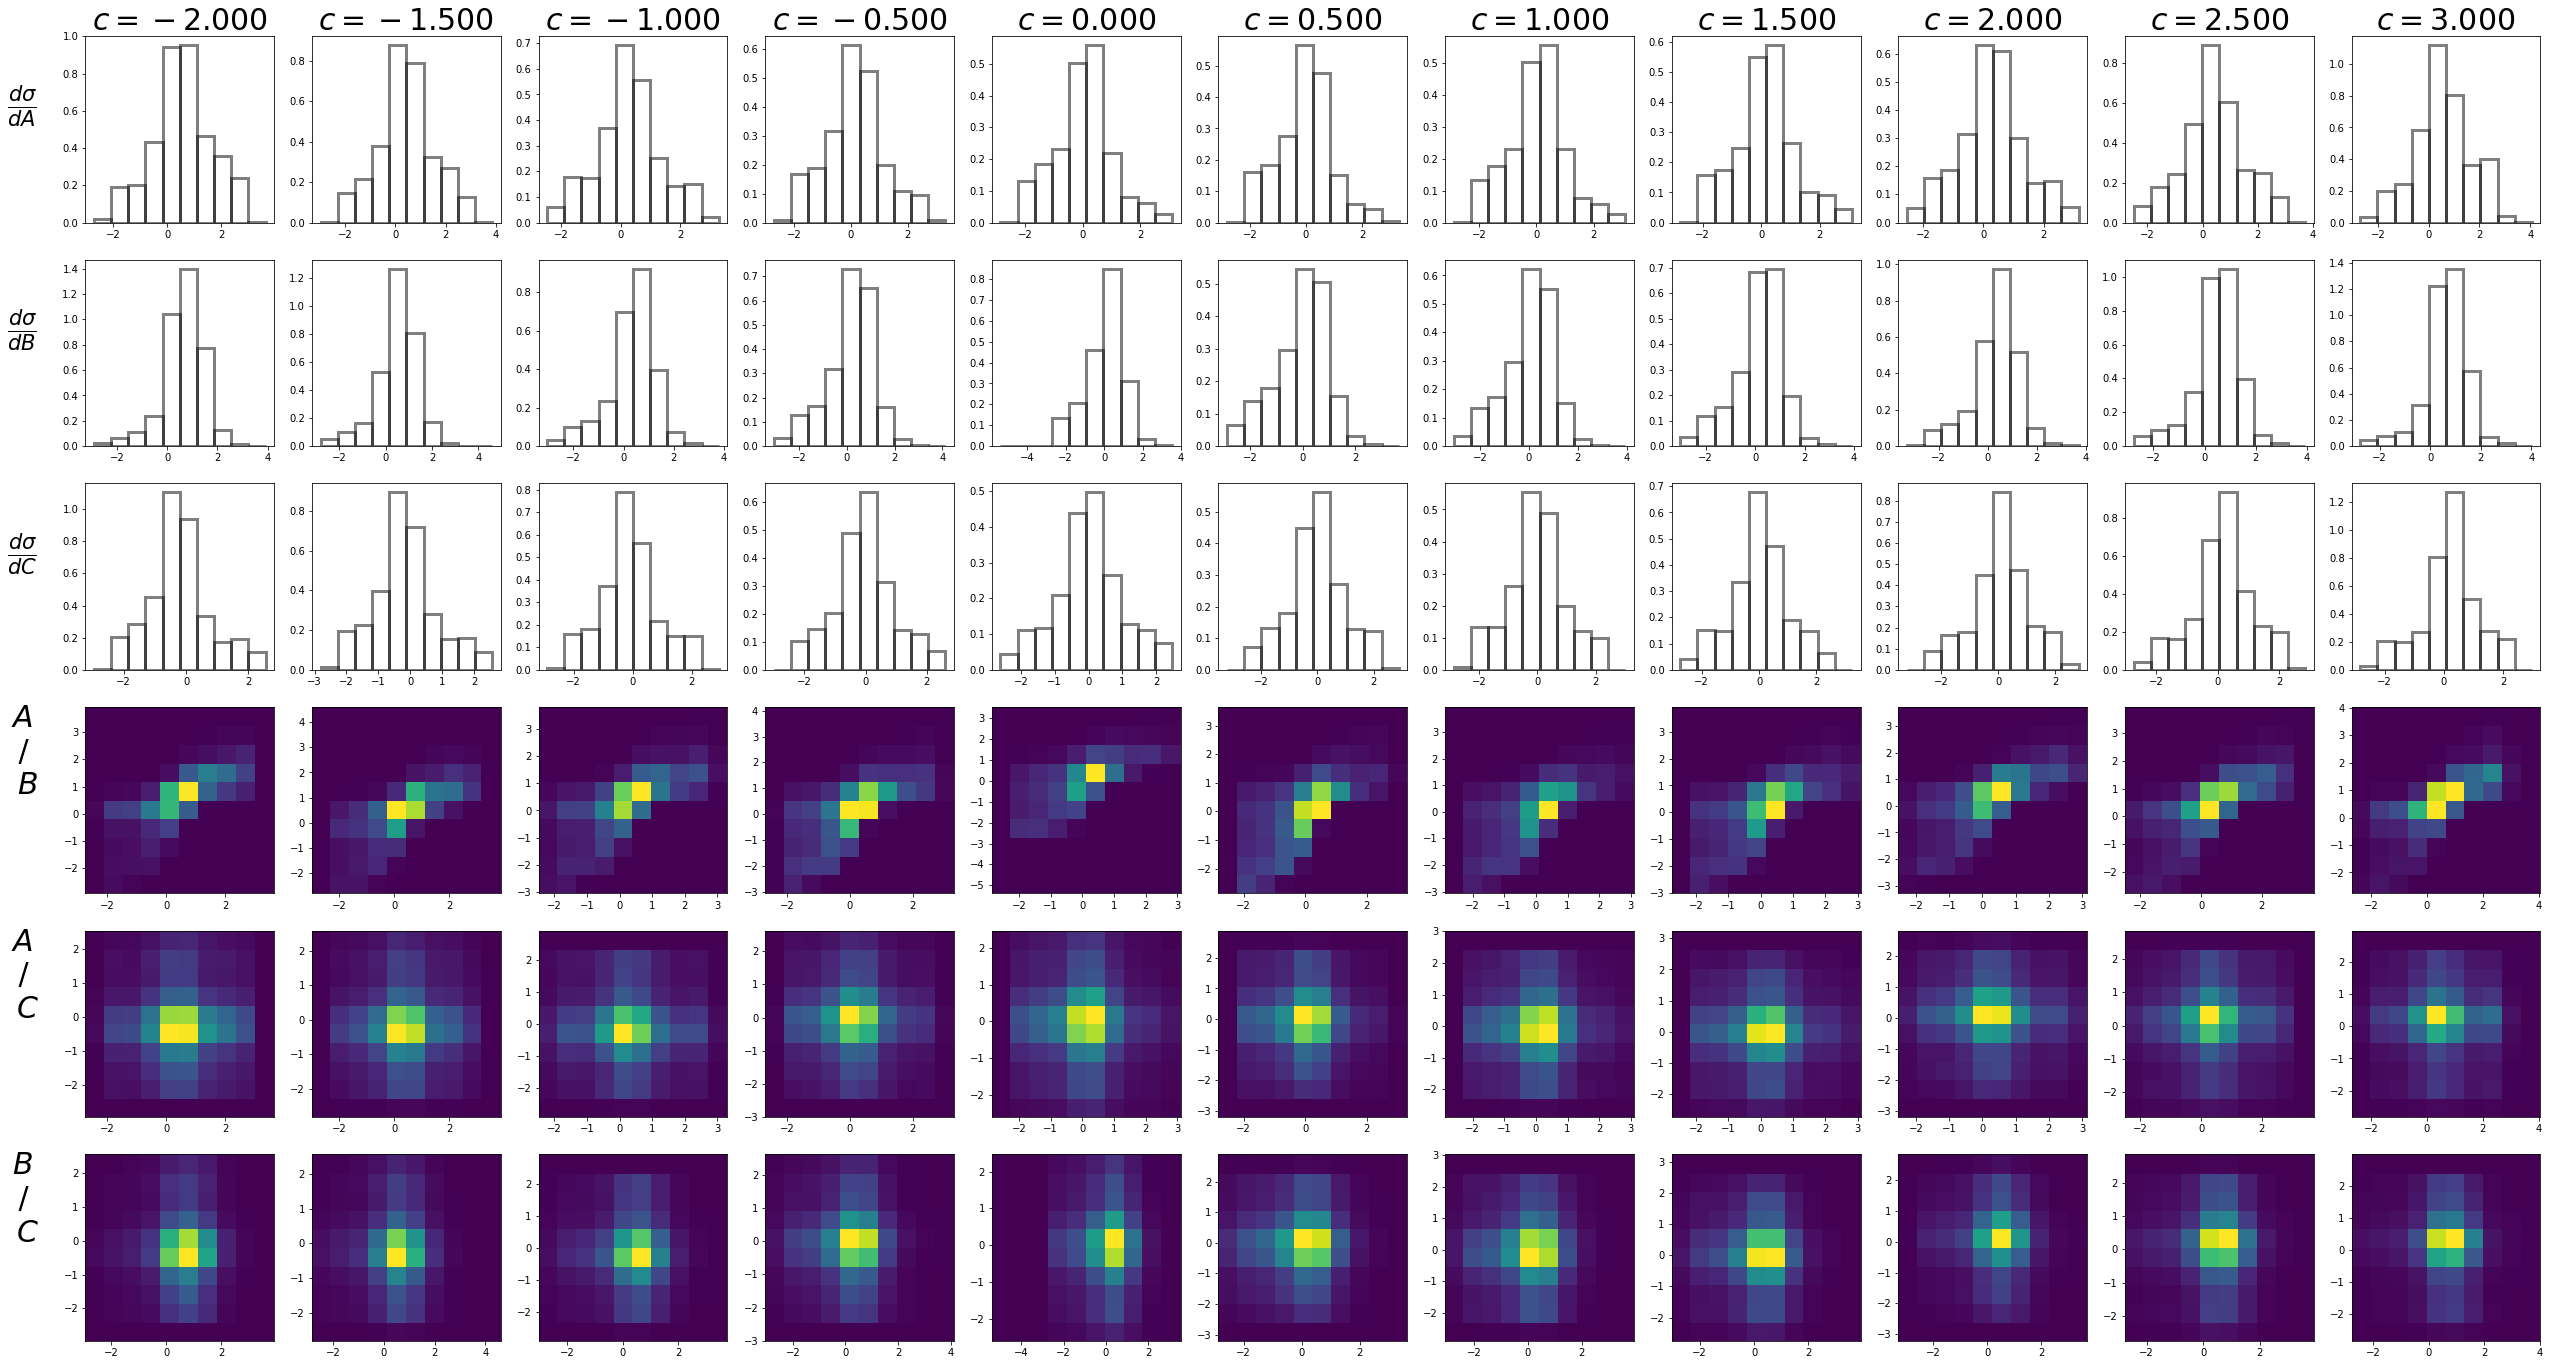

In [24]:
print("Plotting fake dataset")
plot_dataset(mu_scan_points, xsections, fake_DS, fake_weights)